In [122]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import berserk
import os
import random
from tqdm import tqdm
from itertools import chain
from collections import Counter

In [15]:
#extract usernames as list:
with open("../data/usernames_2024-08.txt", "r") as file:
    usernames = file.read().split(",")
random.seed(1)
users_sample = random.sample(usernames, k=500)

In [108]:
api_token = os.environ.get('LICHESS_API_TOKEN')
session = berserk.TokenSession(api_token)
client = berserk.Client(session)

In [150]:
all_ratings = pd.DataFrame()
all_games = pd.DataFrame()
for user in tqdm(users_sample):
    try:
        user_history = client.users.get_rating_history(user)
        for i in range(len(user_history)):
            game_mode_ratings = pd.DataFrame(user_history[i]["points"])
            if game_mode_ratings.shape[0] > 0:
                game_mode_ratings.insert(0, "username", user)
                game_mode_ratings['month'] += 1  # because months in lichess API start at 0 we have to increment by 1
                game_mode_ratings["mode"] = user_history[i]["name"]
                all_ratings = pd.concat([all_ratings, game_mode_ratings])
        # user_games = pd.DataFrame(list(client.games.export_by_player(user)))
        # user_games.insert(0, "username", user)
        # all_games = pd.concat([all_games, user_games])
    except KeyError:
      pass
    except berserk.exceptions.ResponseError:
      pass

100%|██████████| 500/500 [02:27<00:00,  3.40it/s]


In [151]:
all_ratings["date"] = pd.to_datetime(all_ratings[all_ratings.columns[1:4]])
all_ratings = all_ratings.drop(labels=["year","month","day"], axis=1)
all_ratings = all_ratings.sort_values(["username", "date"])
all_ratings = all_ratings.reset_index(drop=True)

In [153]:
all_ratings["date_prev_activity"] = all_ratings["date"].shift(1)
all_ratings["days_since_prev"] = (all_ratings["date"] - all_ratings["date_prev_activity"])/ np.timedelta64(1, 'D')
all_ratings.loc[all_ratings.groupby('username')['date'].idxmin(), 'days_since_prev'] = np.nan

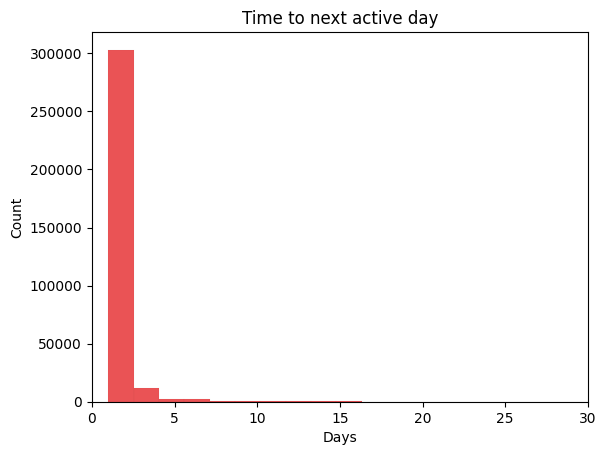

In [167]:
_ = sns.histplot([rating for rating in all_ratings["days_since_prev"] if rating>0], bins = 2000)
_ = plt.xlim(0,30)
_ = plt.title("Time to next active day")
_ = plt.xlabel("Days")

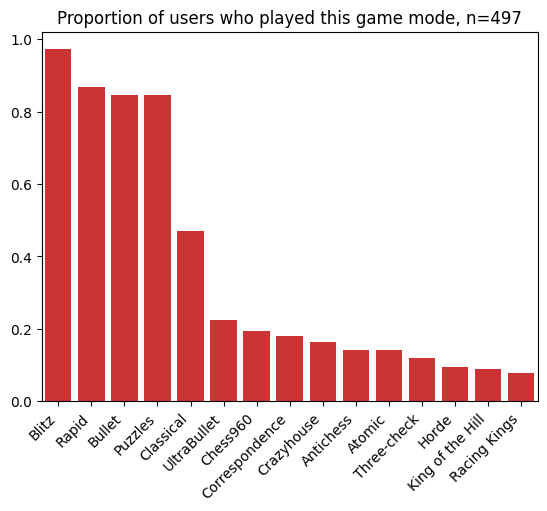

In [166]:
game_mode_frequency_desc = dict(sorted(game_mode_frequency.items(),key= lambda x: x[1], reverse=True))
n = len(all_ratings["username"].unique())
_ = sns.barplot(x=game_mode_frequency_desc.keys(),y=map(lambda x: x/n, game_mode_frequency_desc.values()))
_ = plt.xticks(rotation=45, ha="right")
_ = plt.title(f"Proportion of users who played this game mode, n={n}")

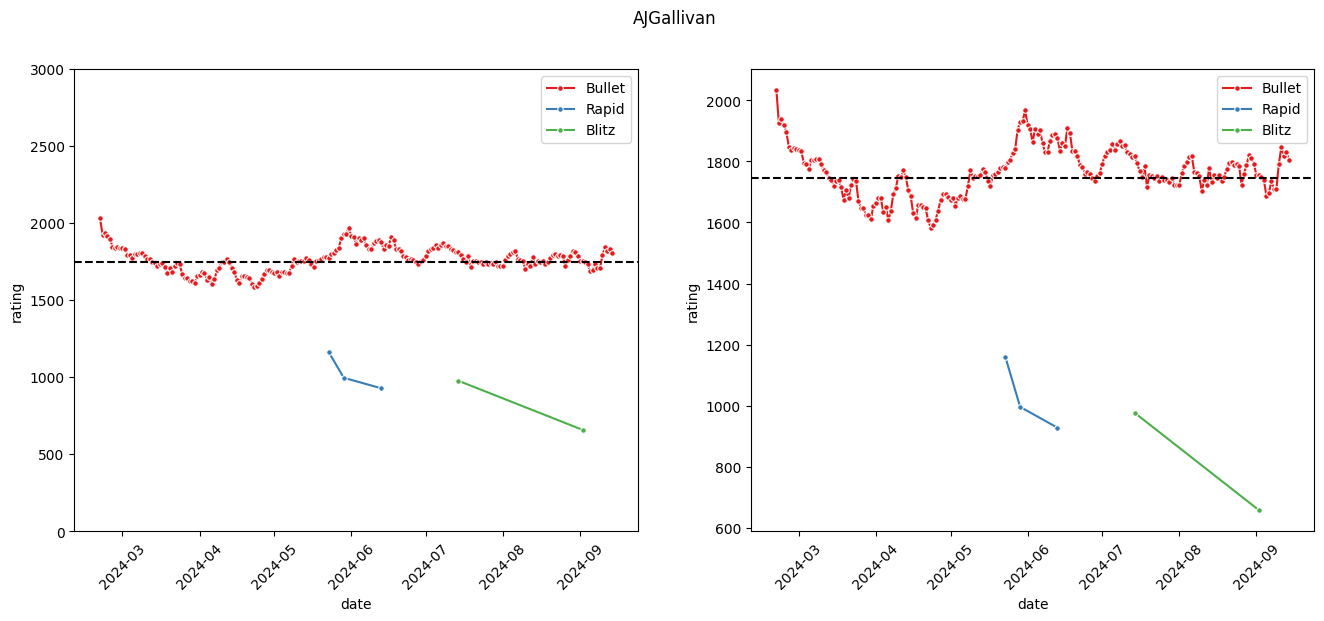

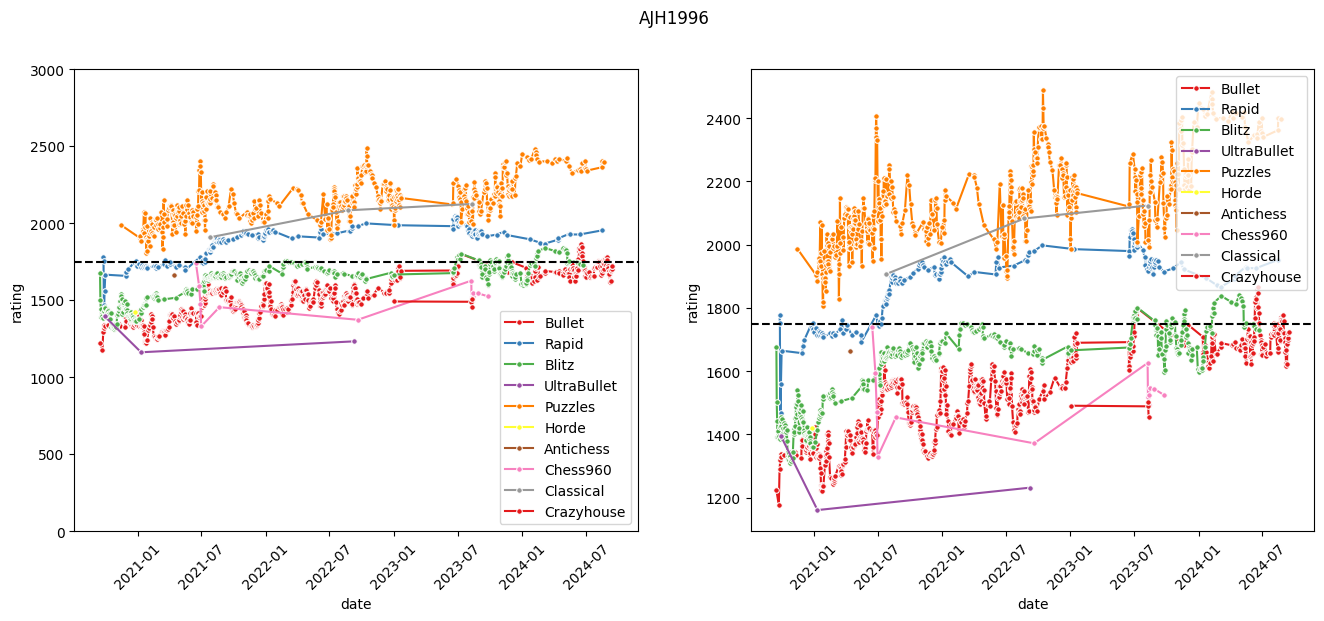

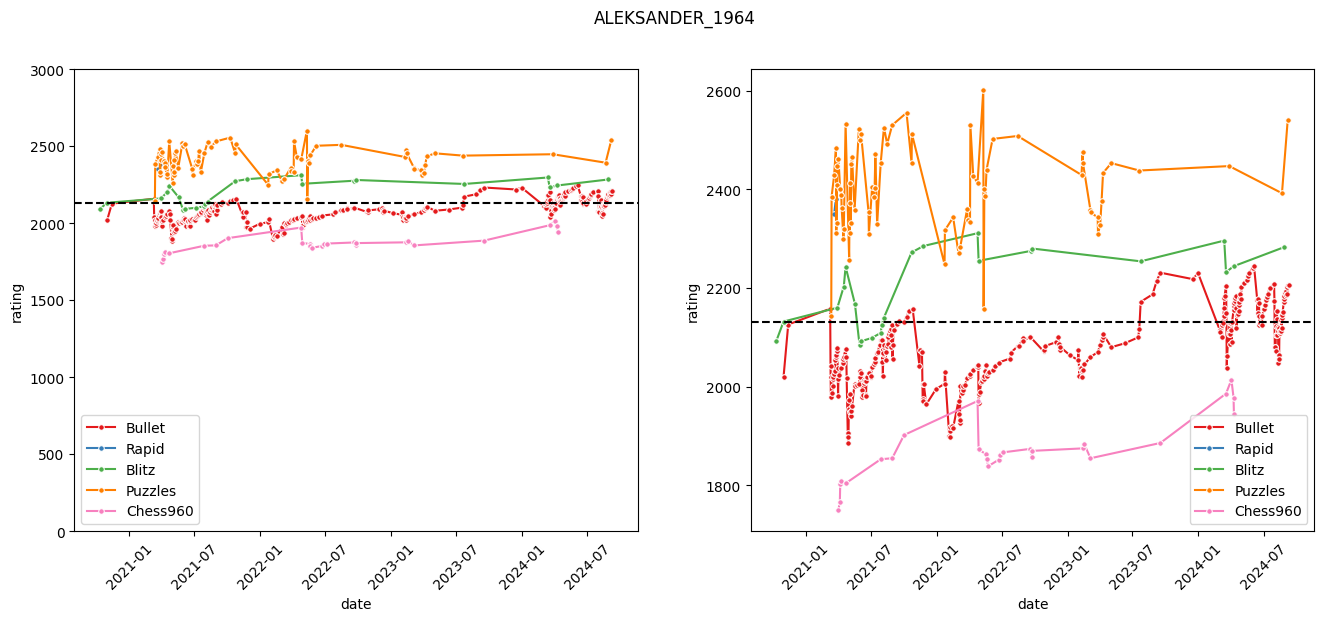

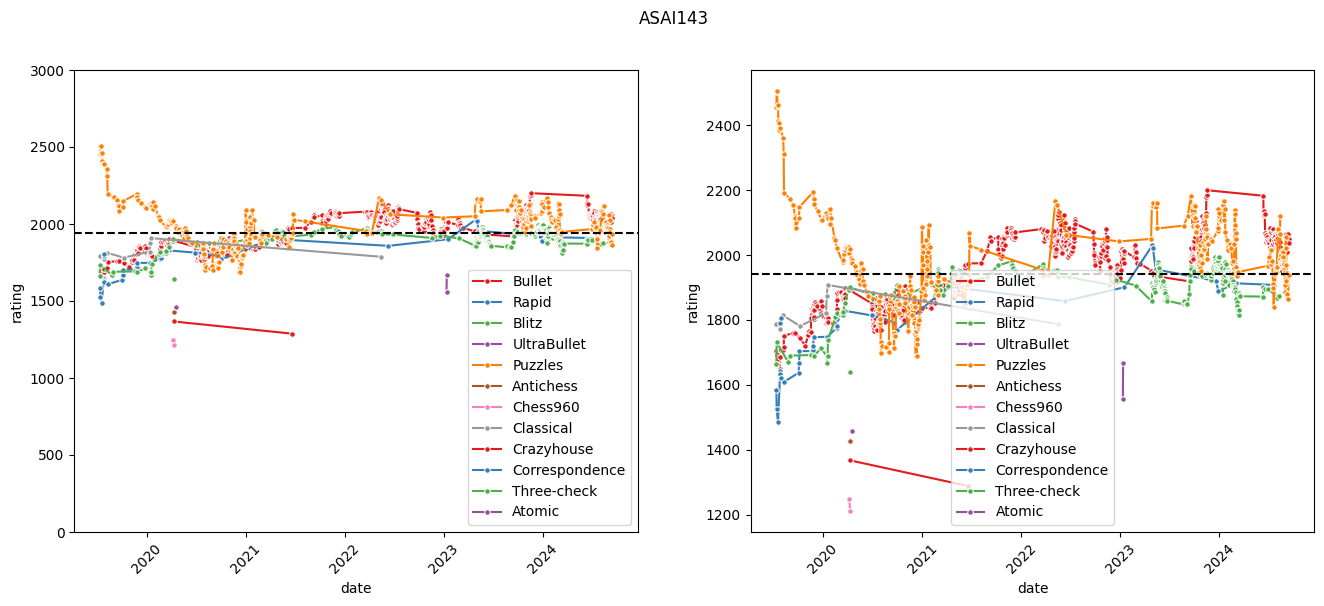

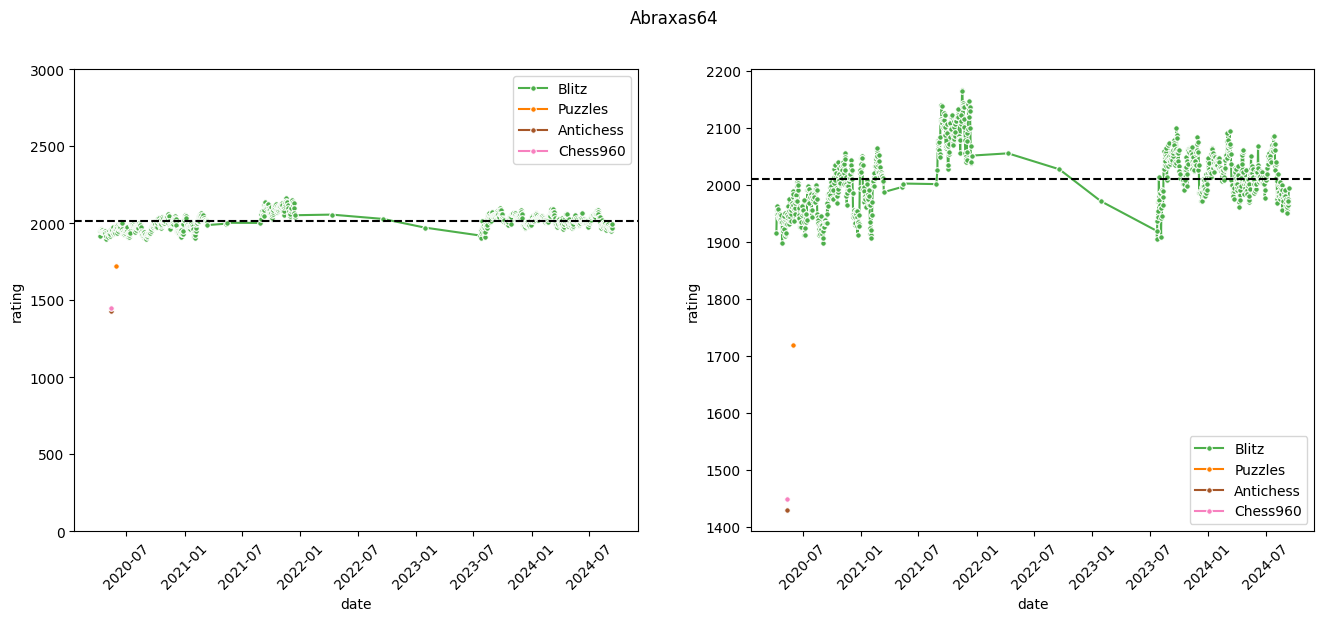

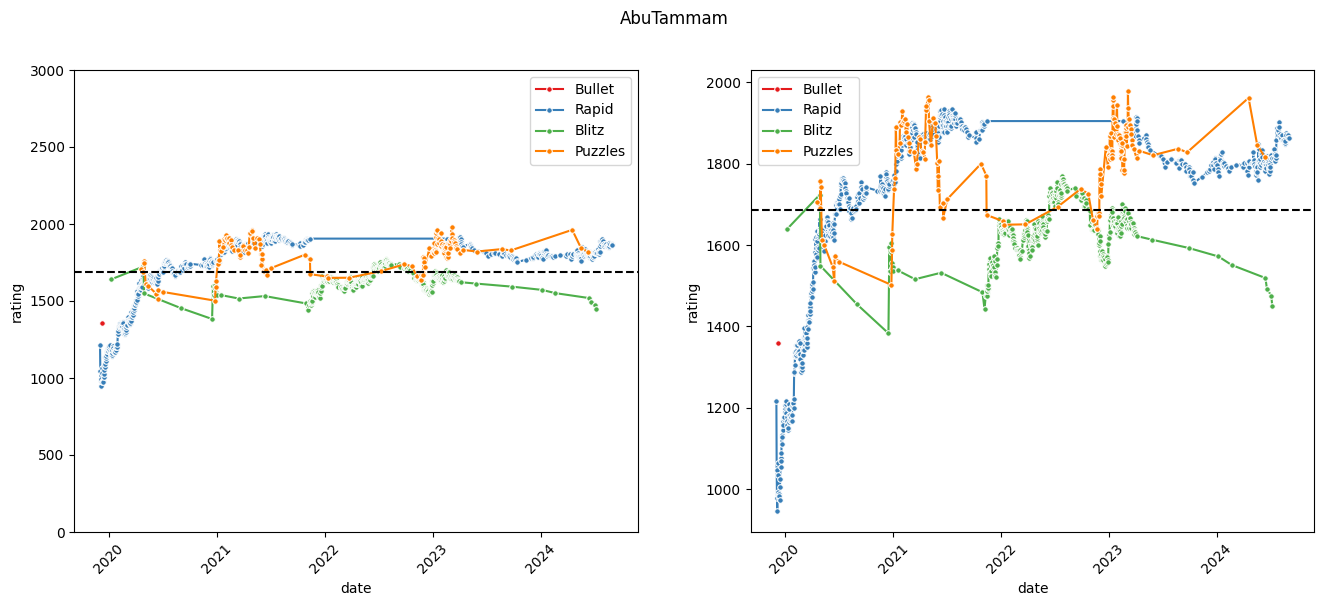

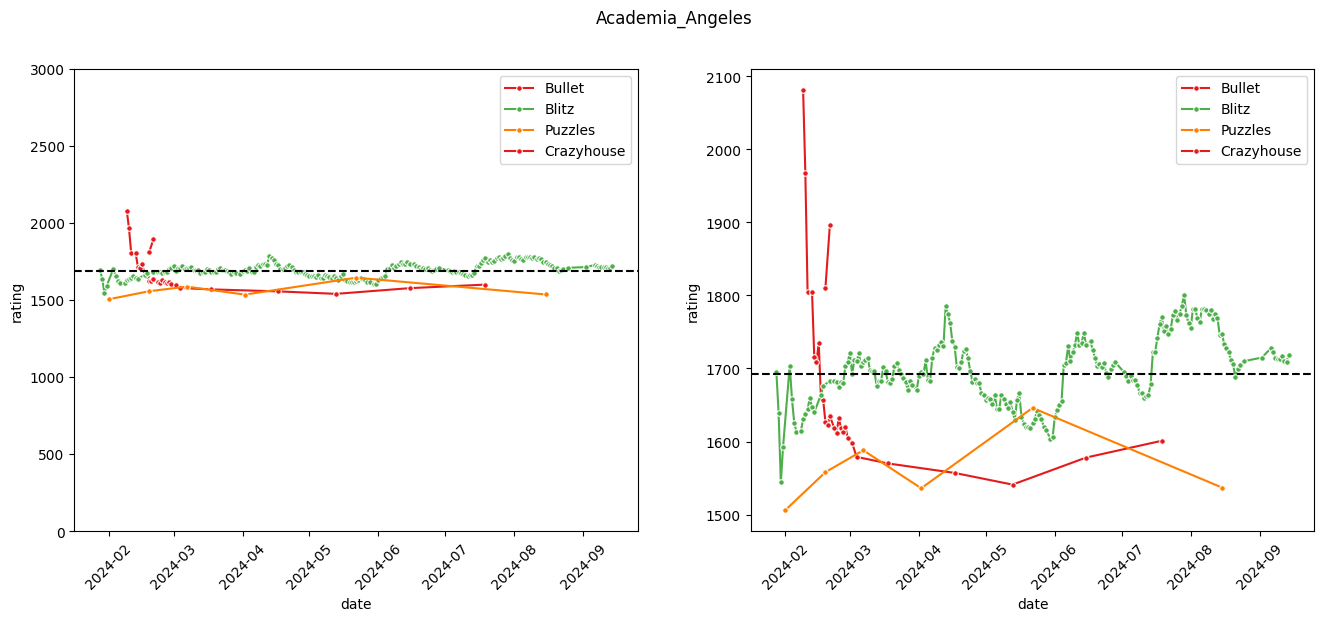

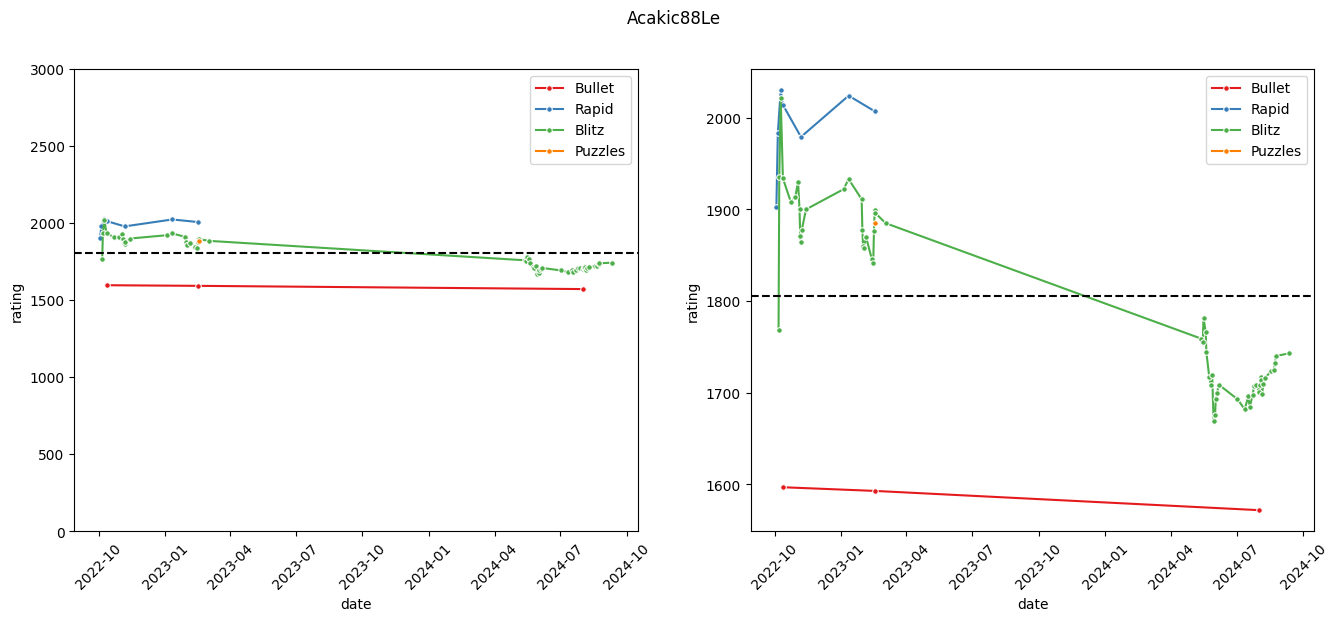

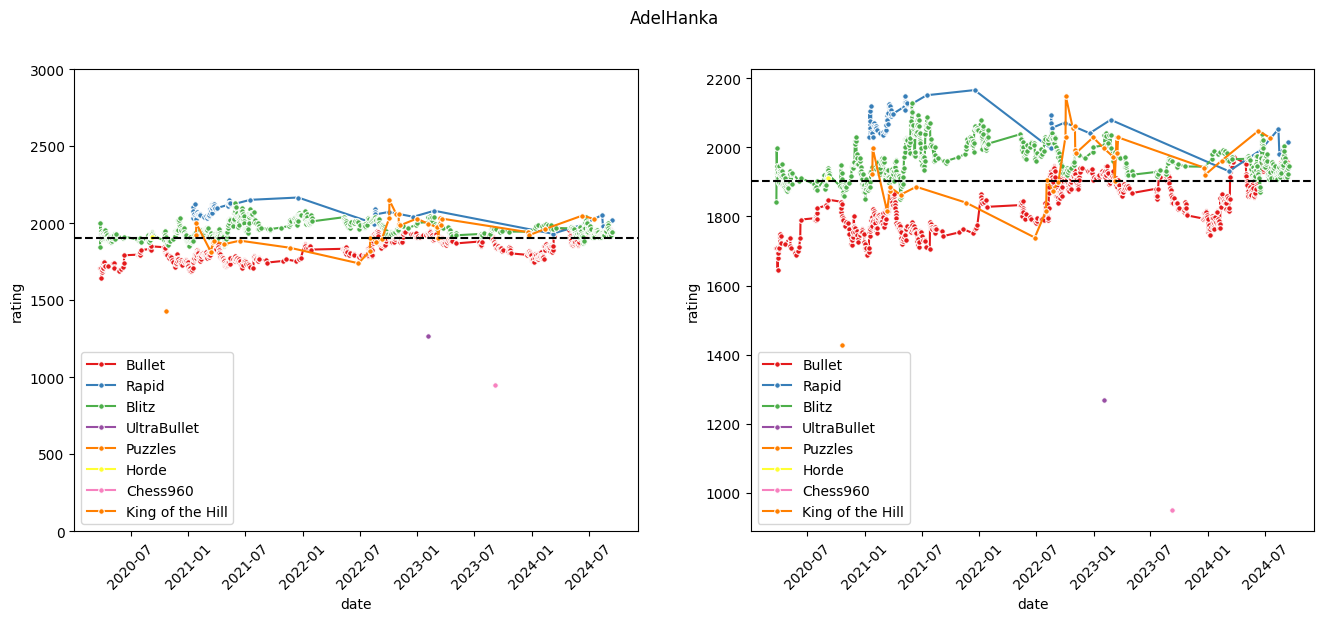

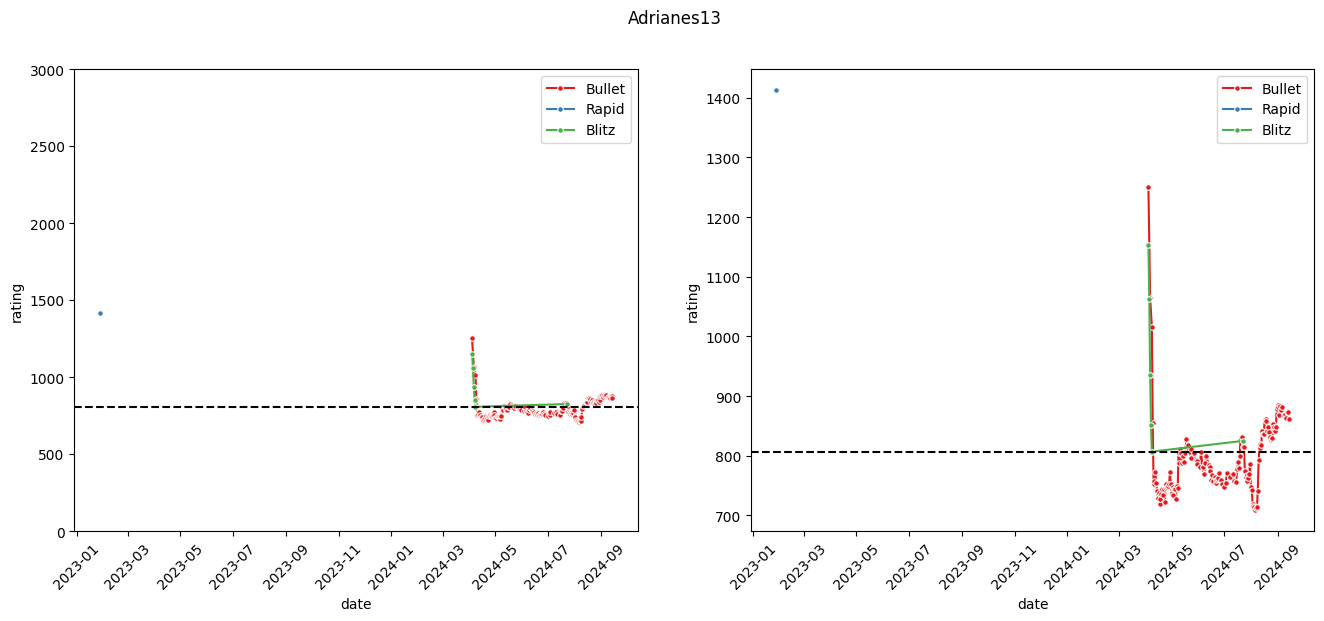

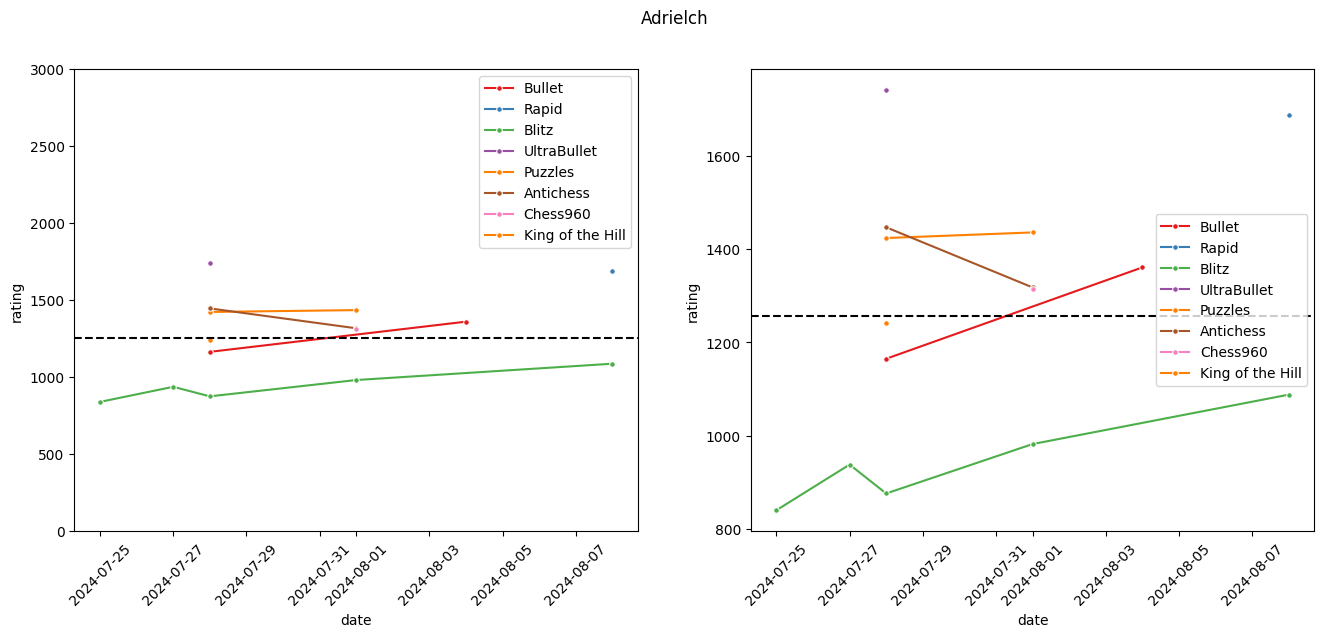

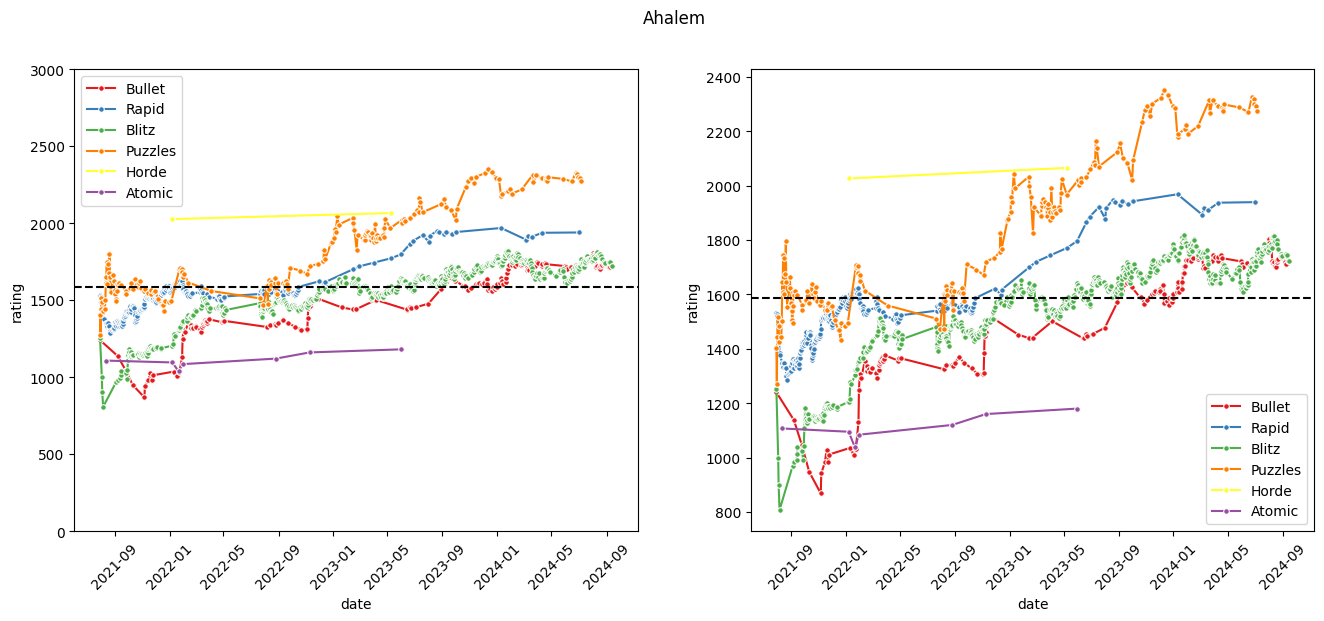

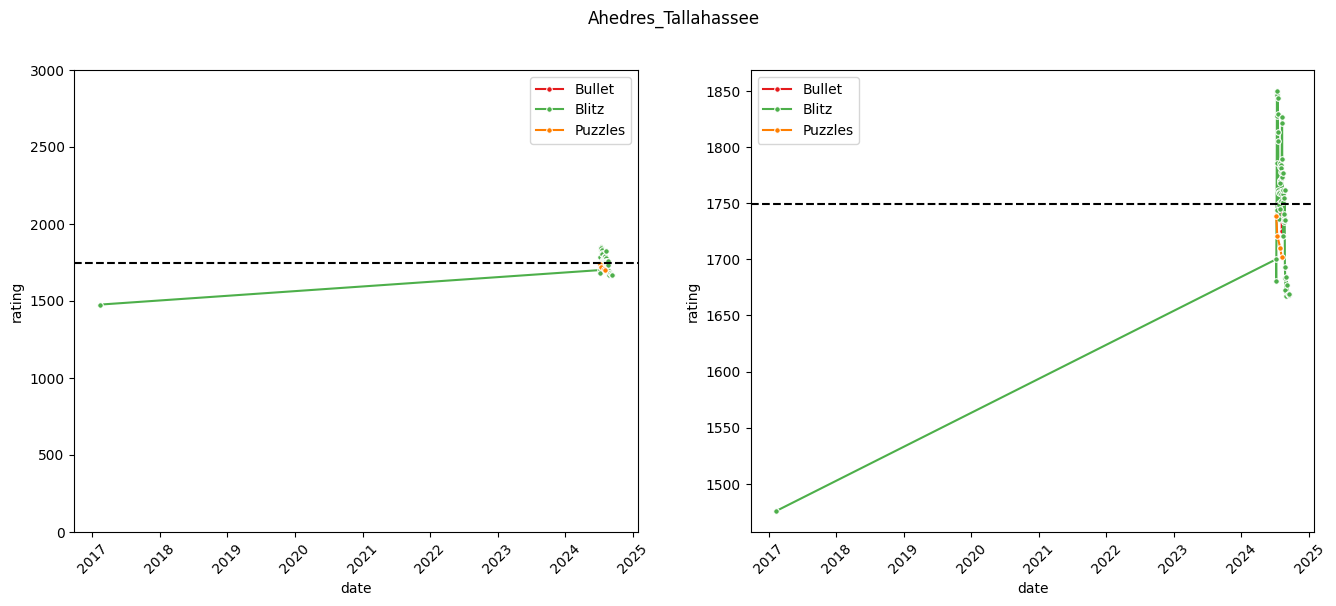

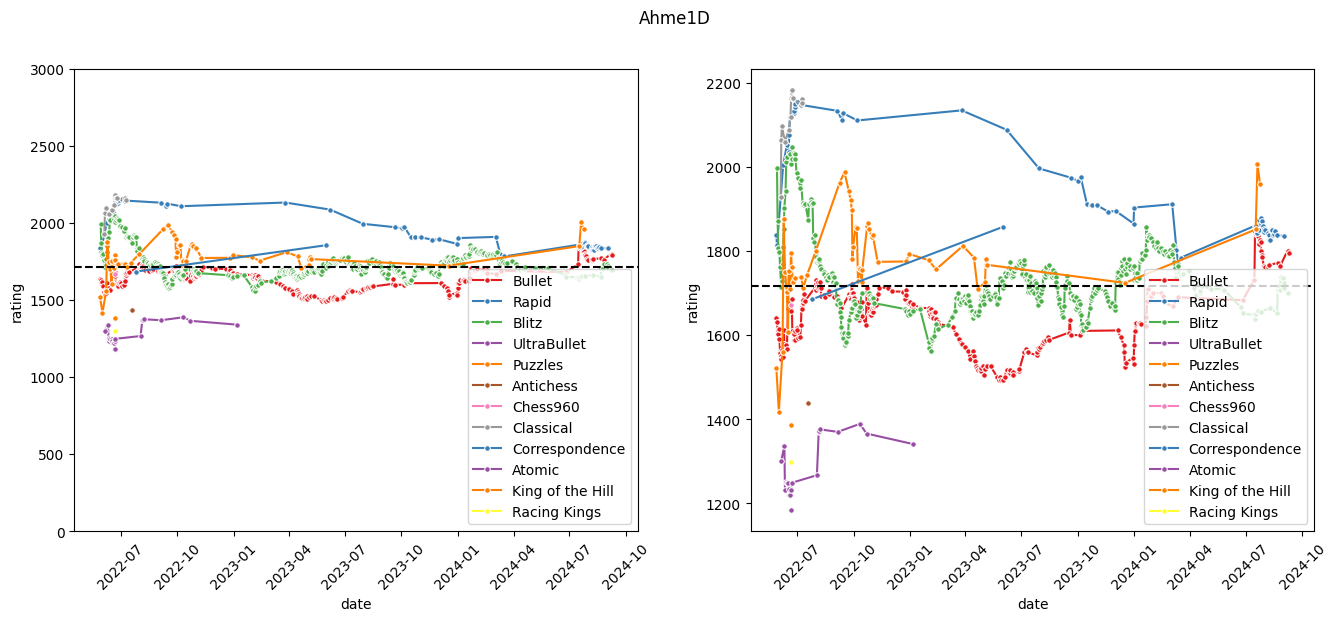

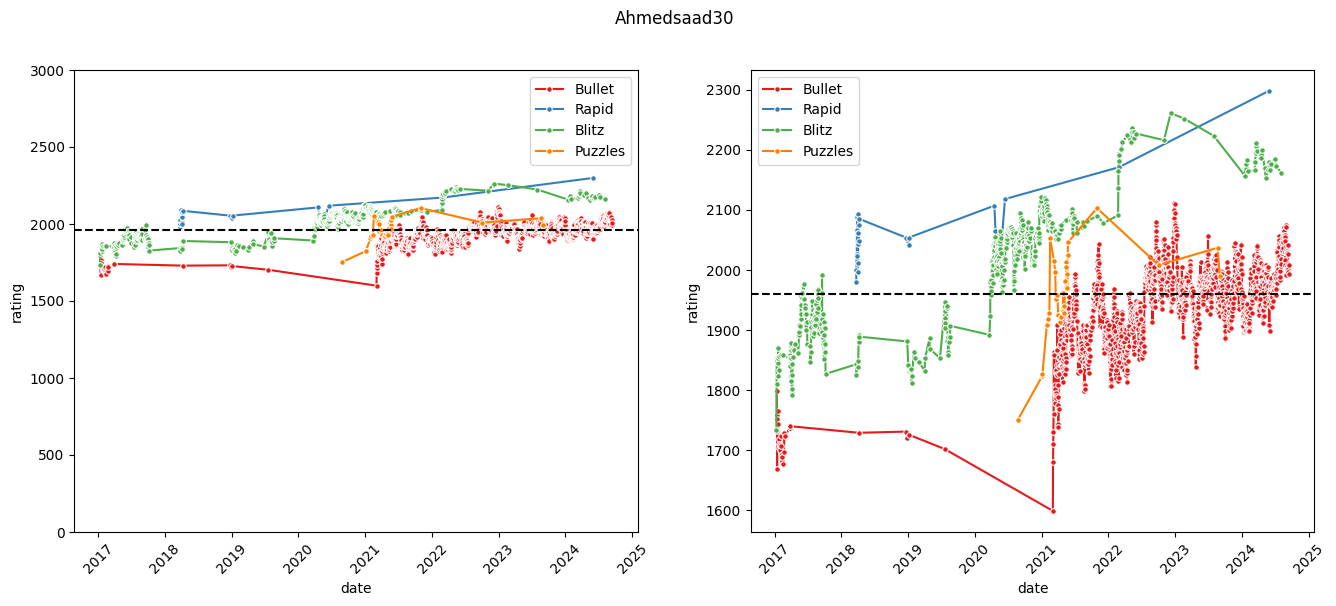

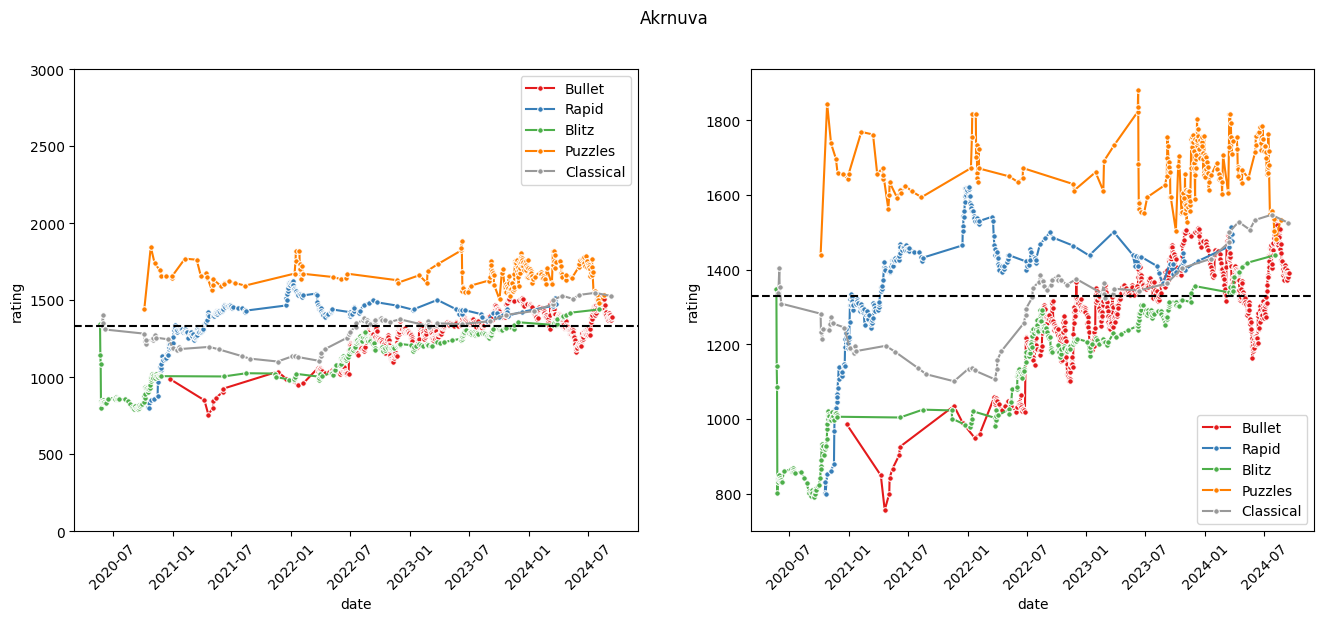

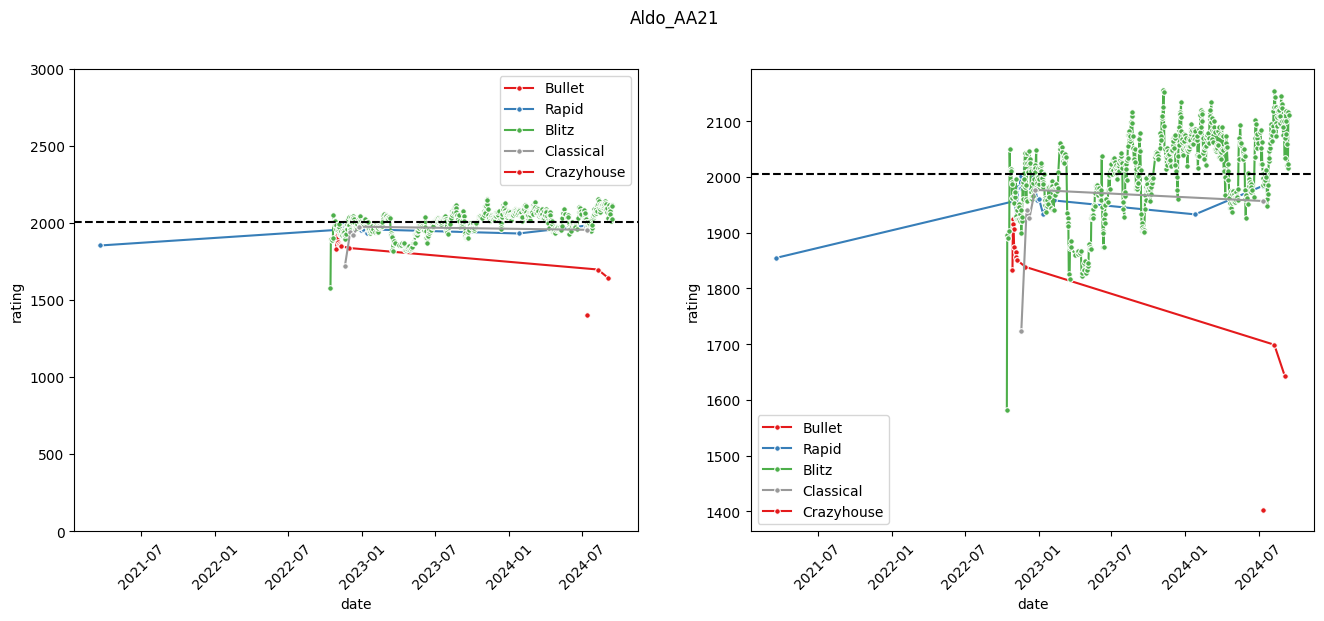

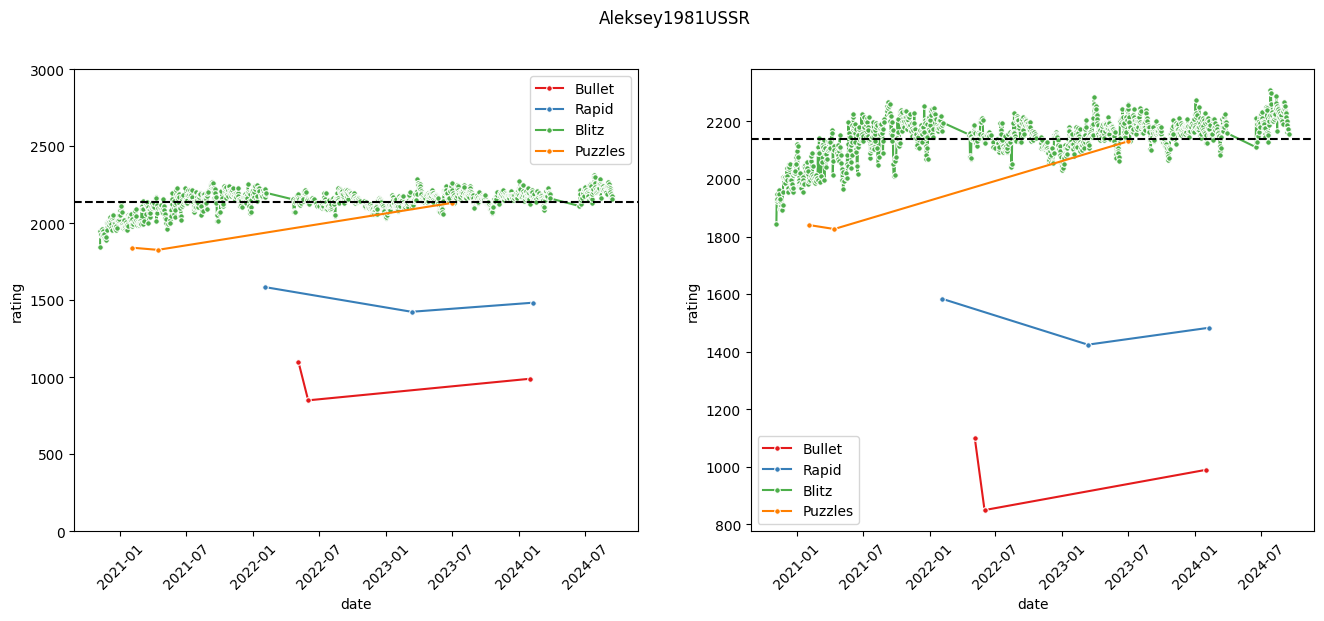

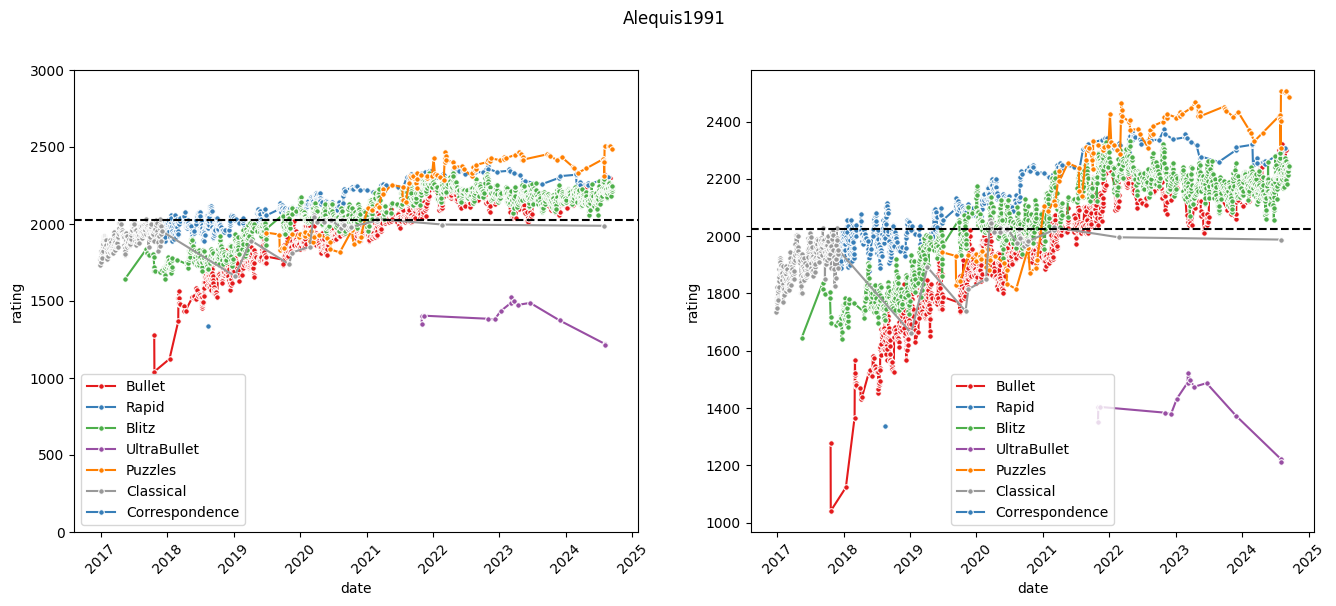

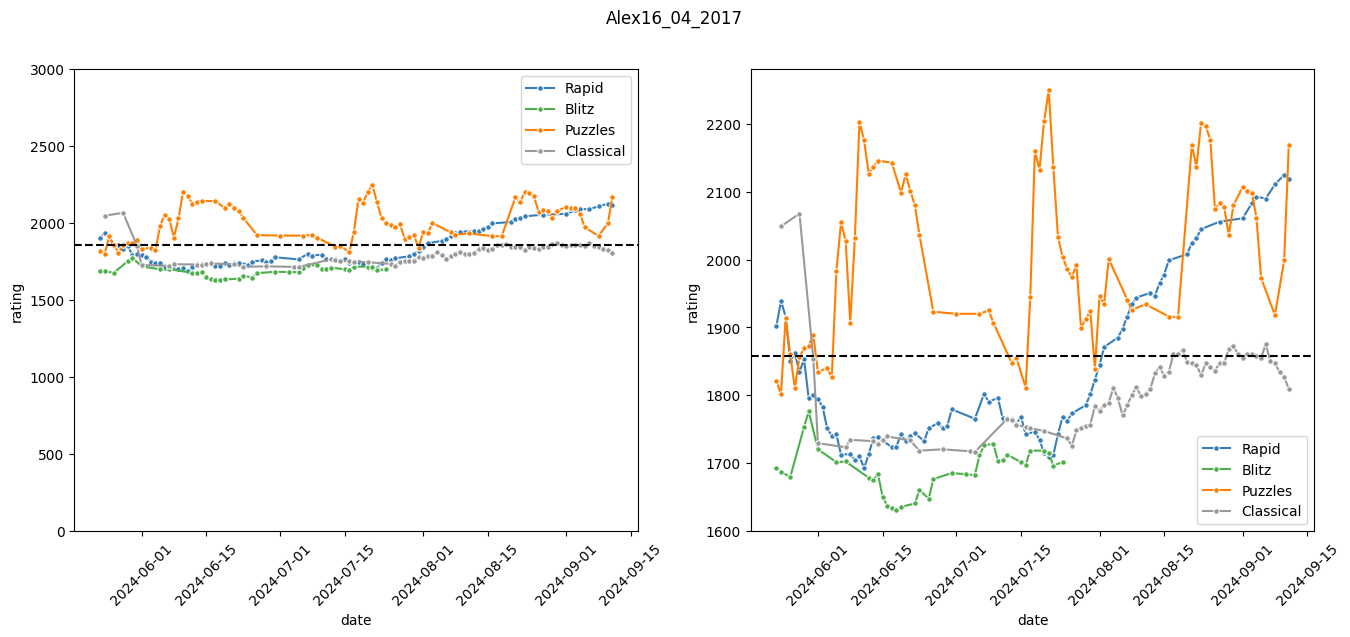

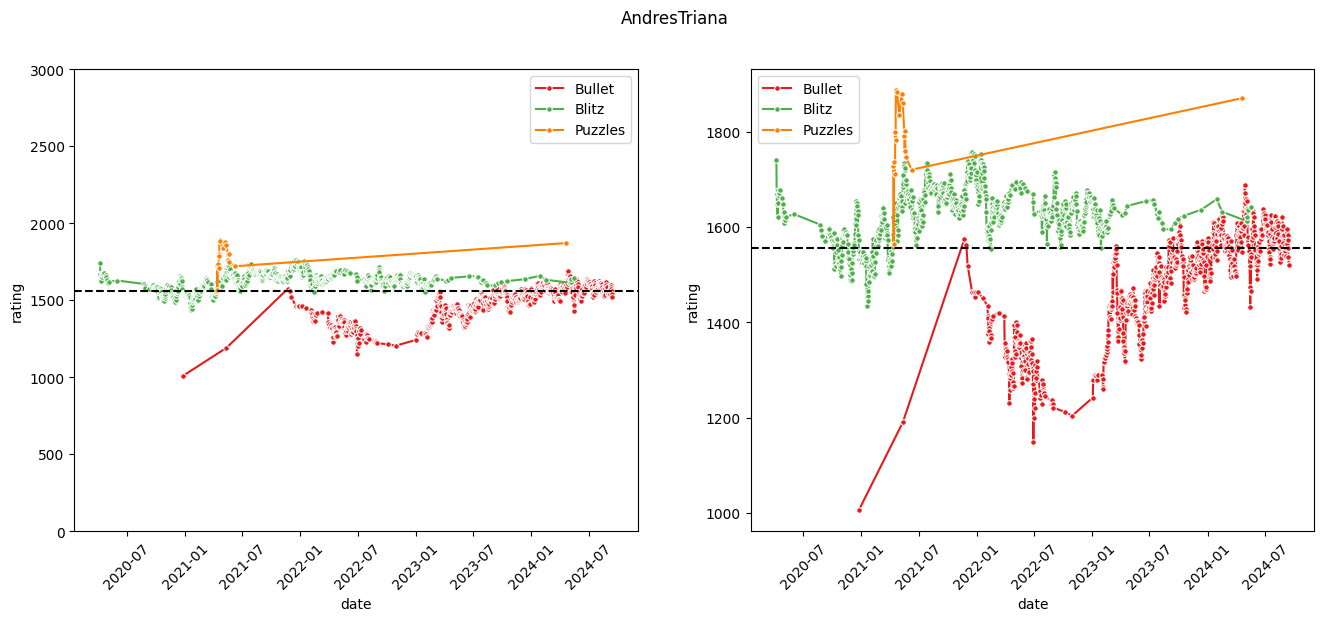

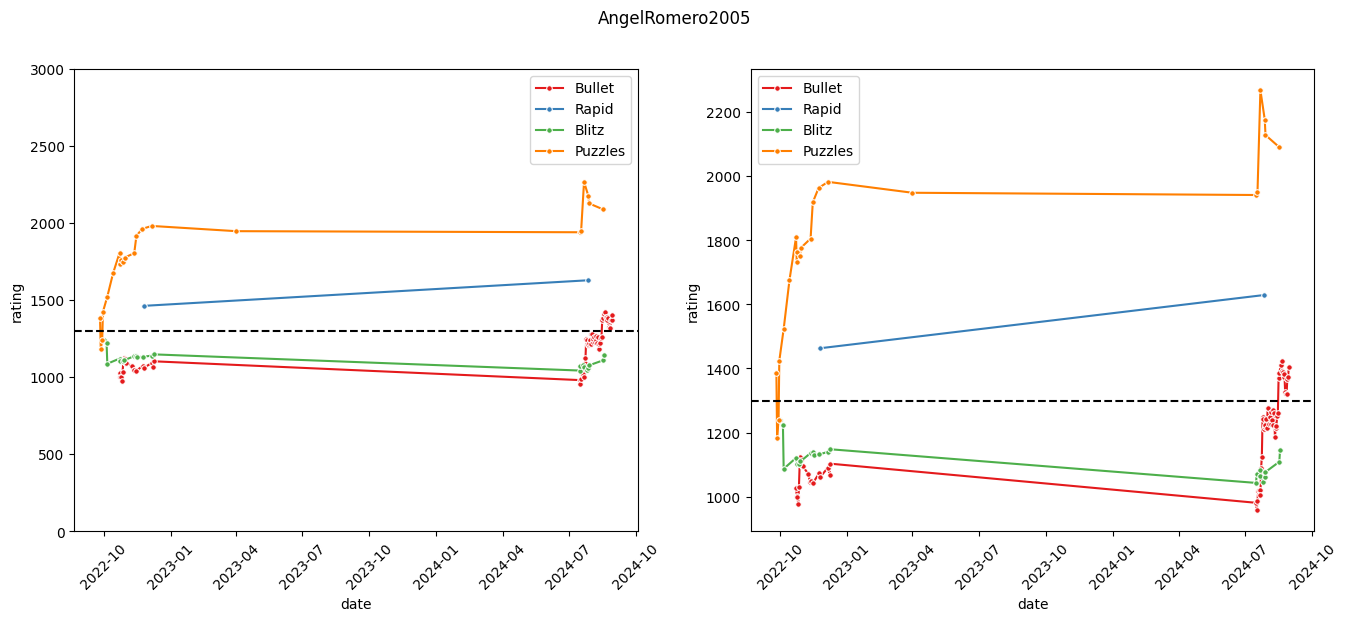

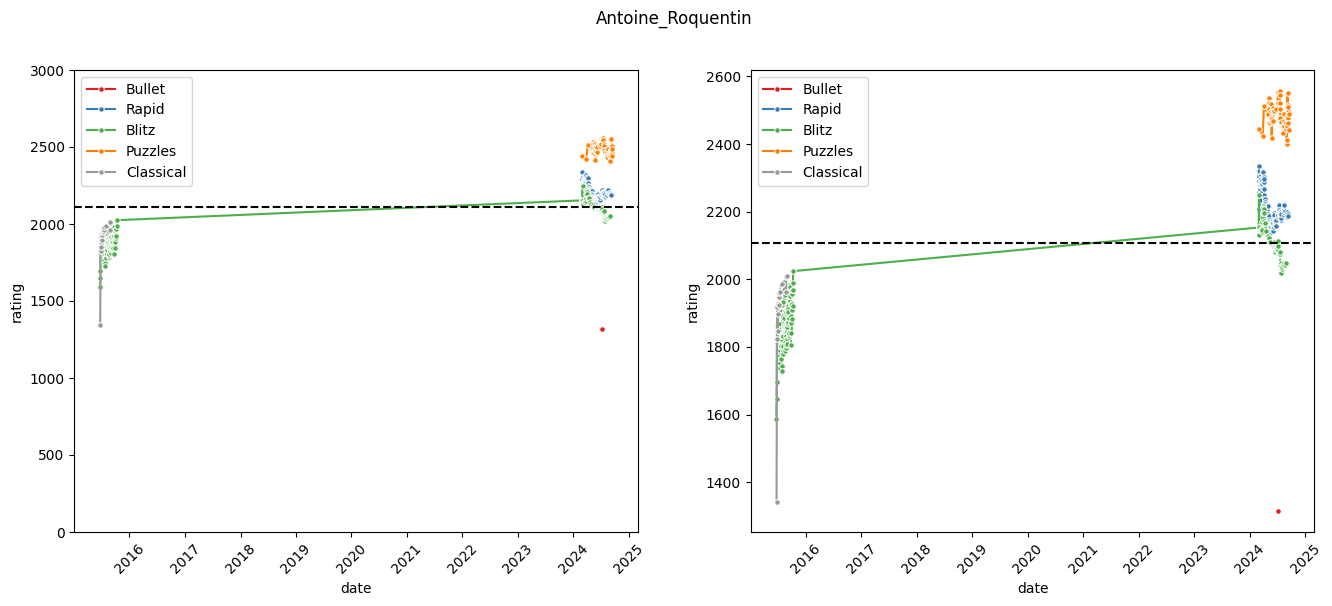

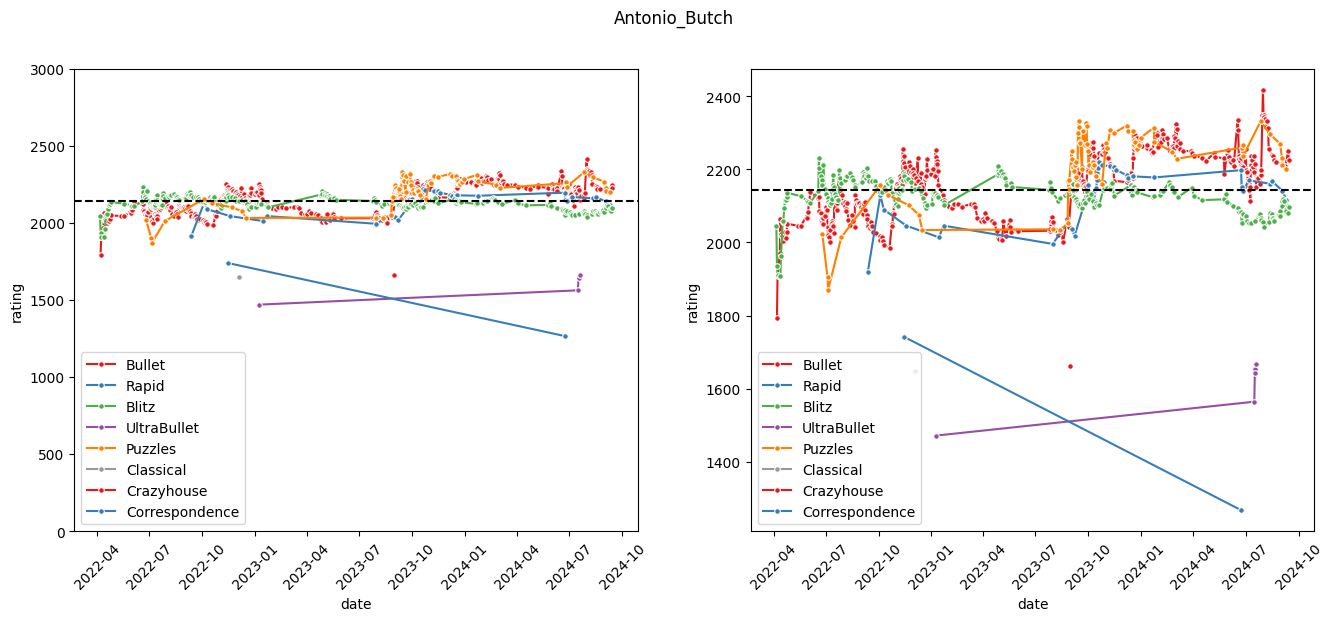

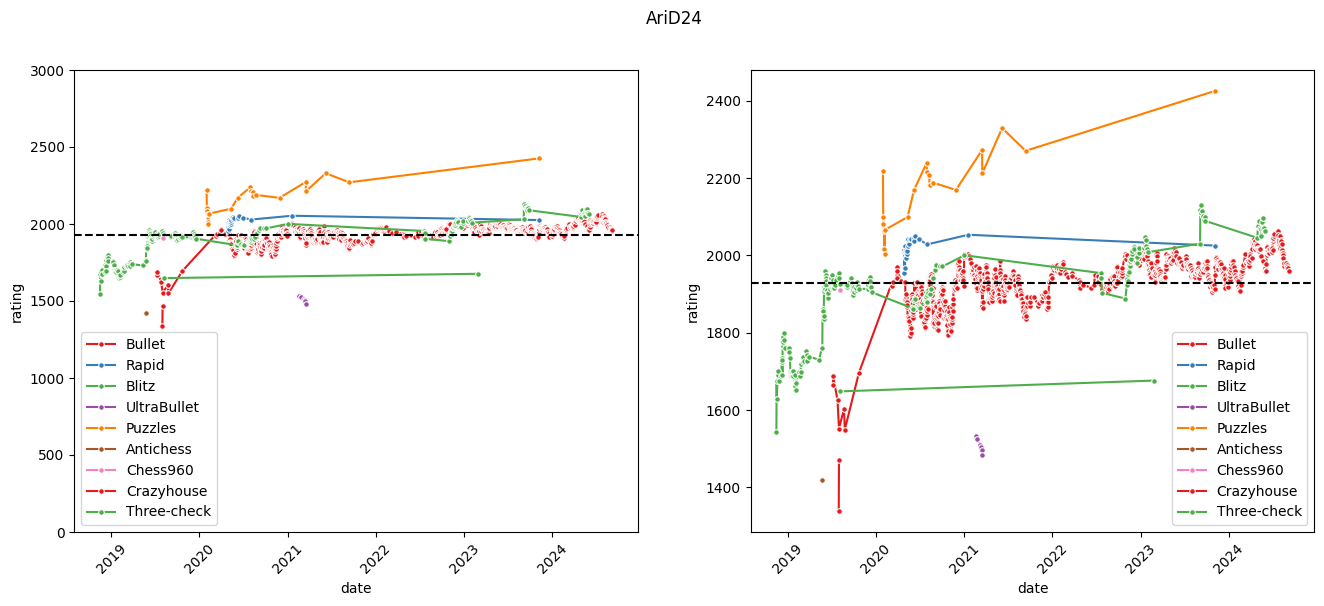

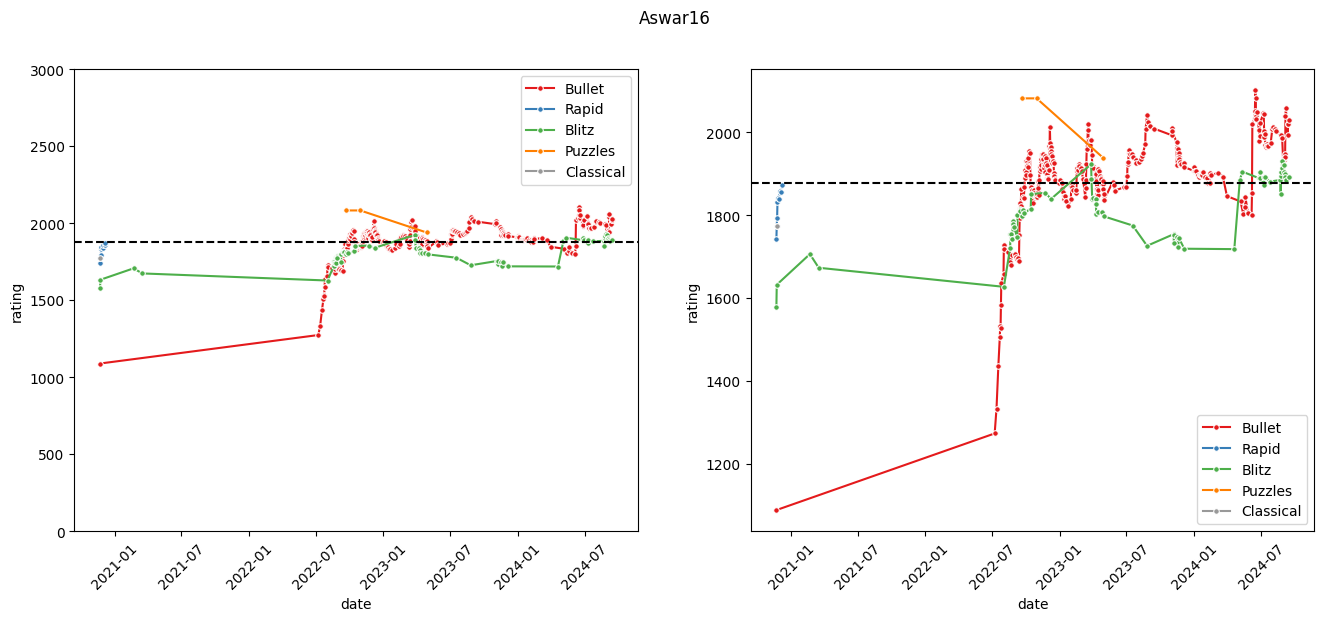

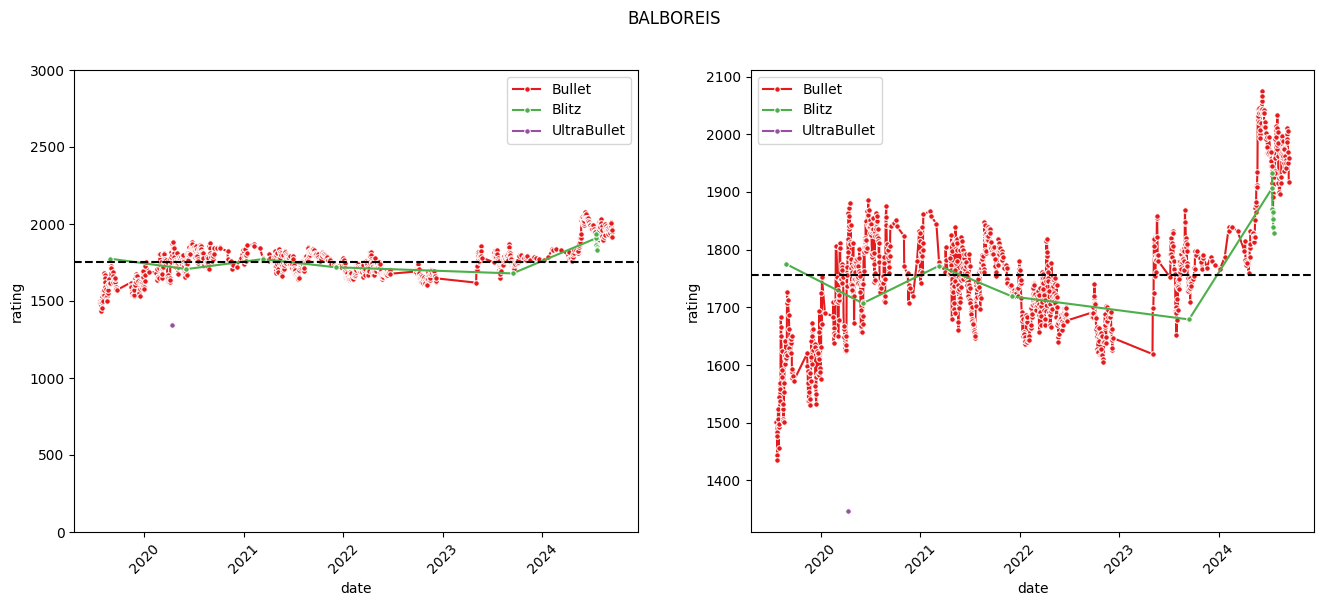

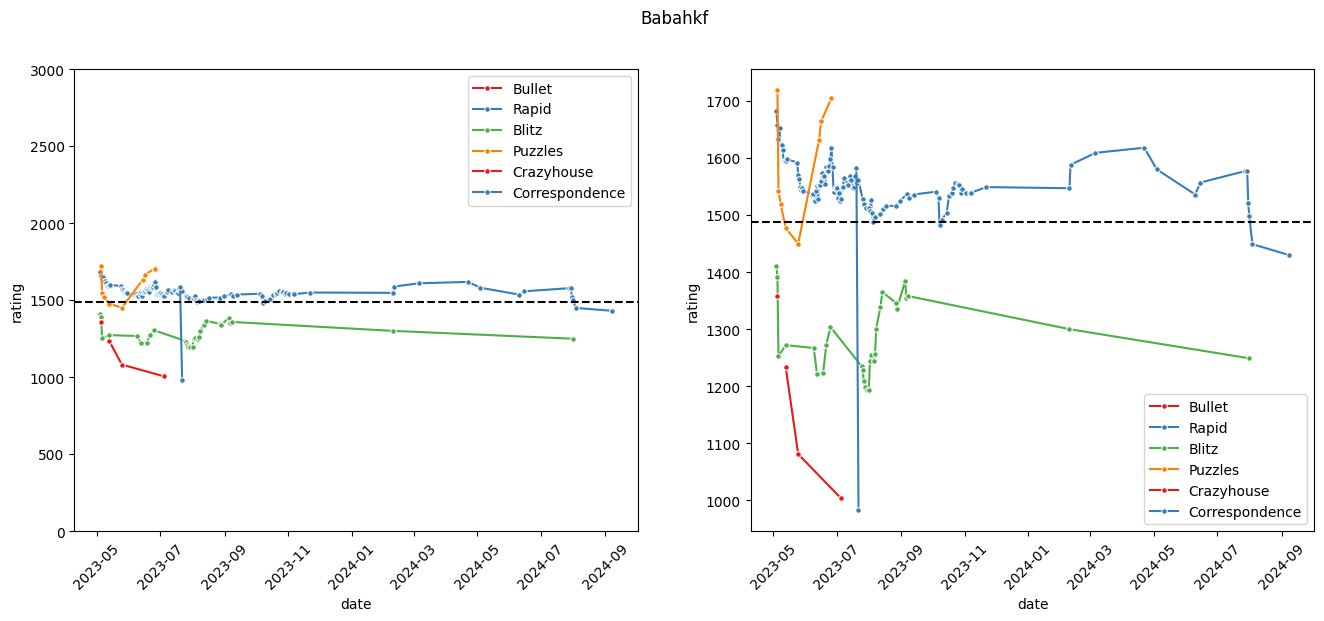

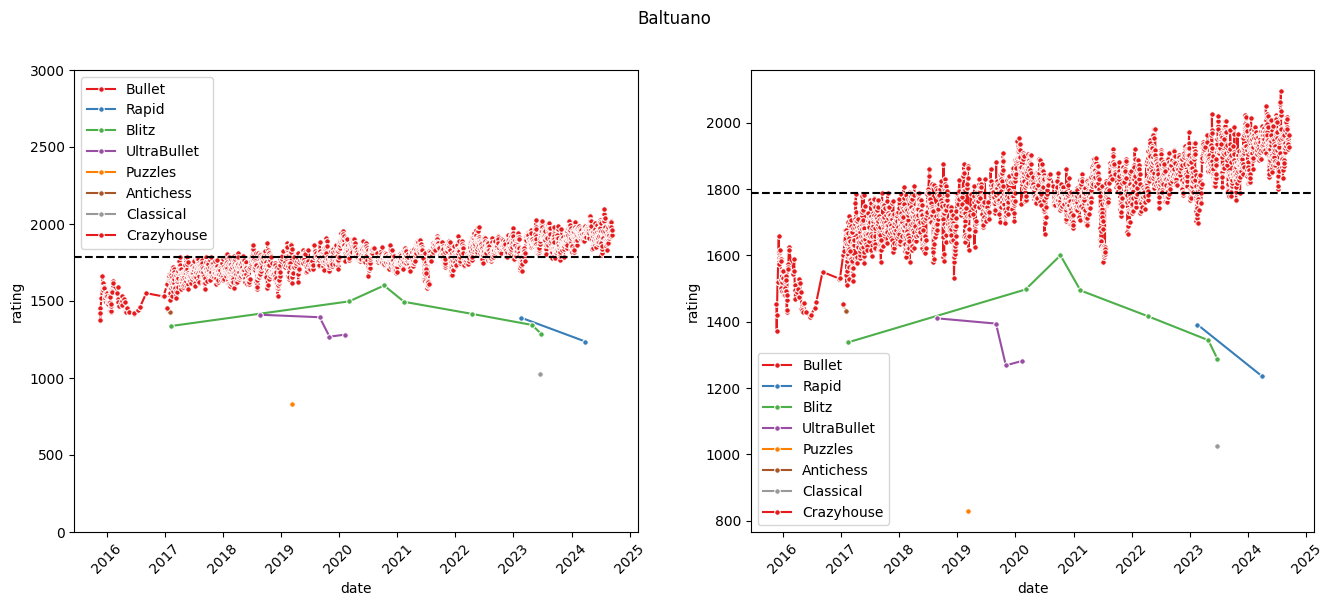

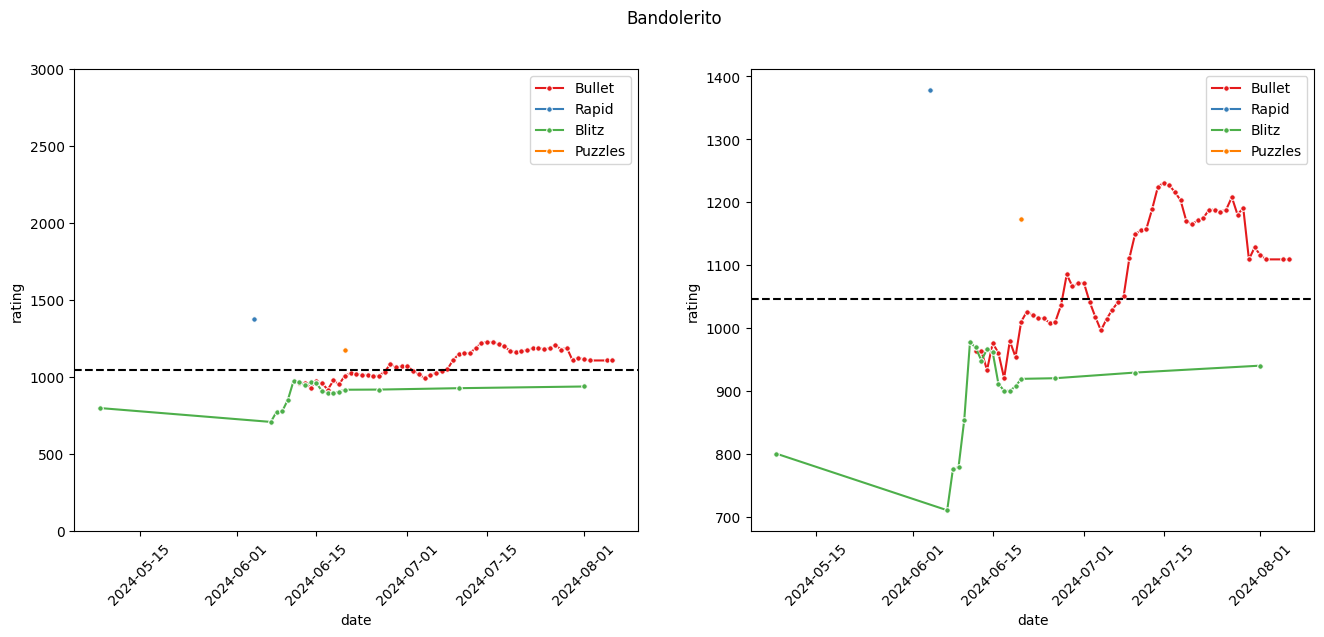

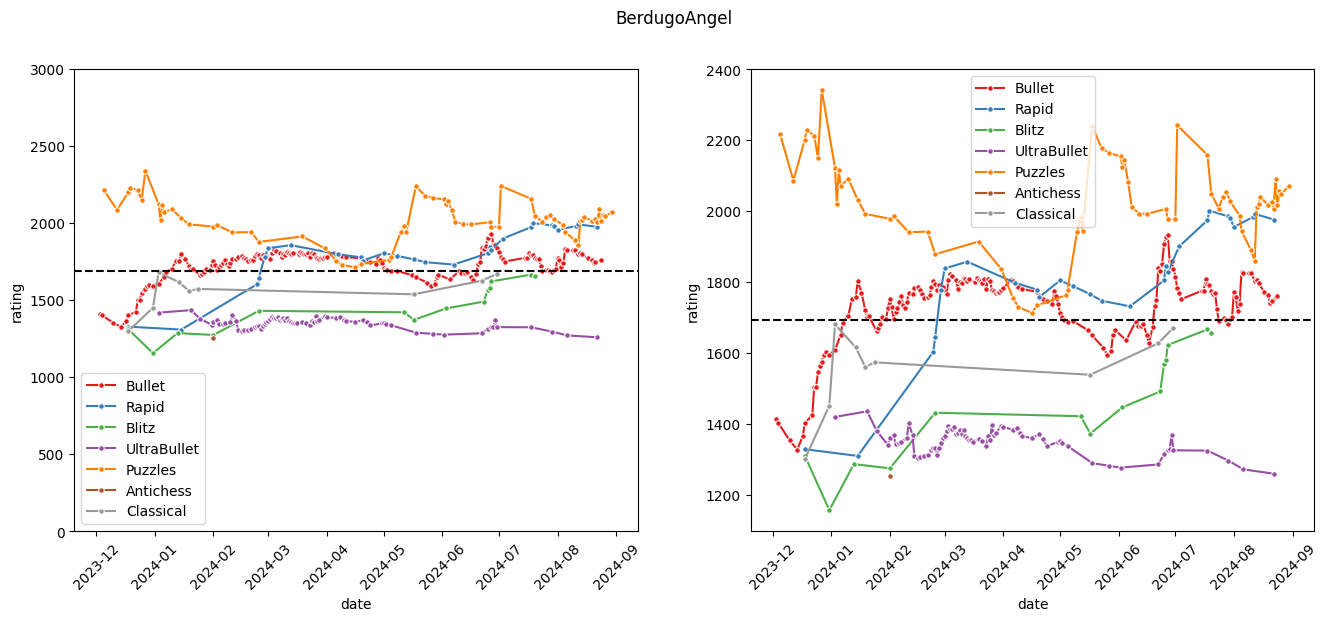

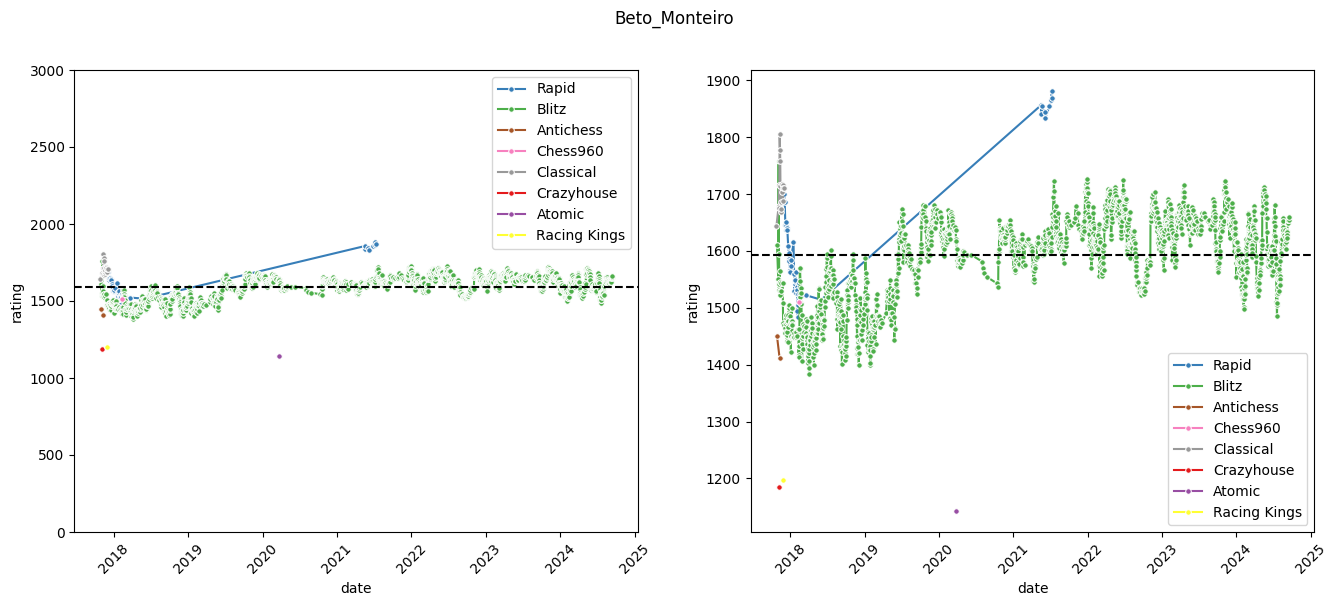

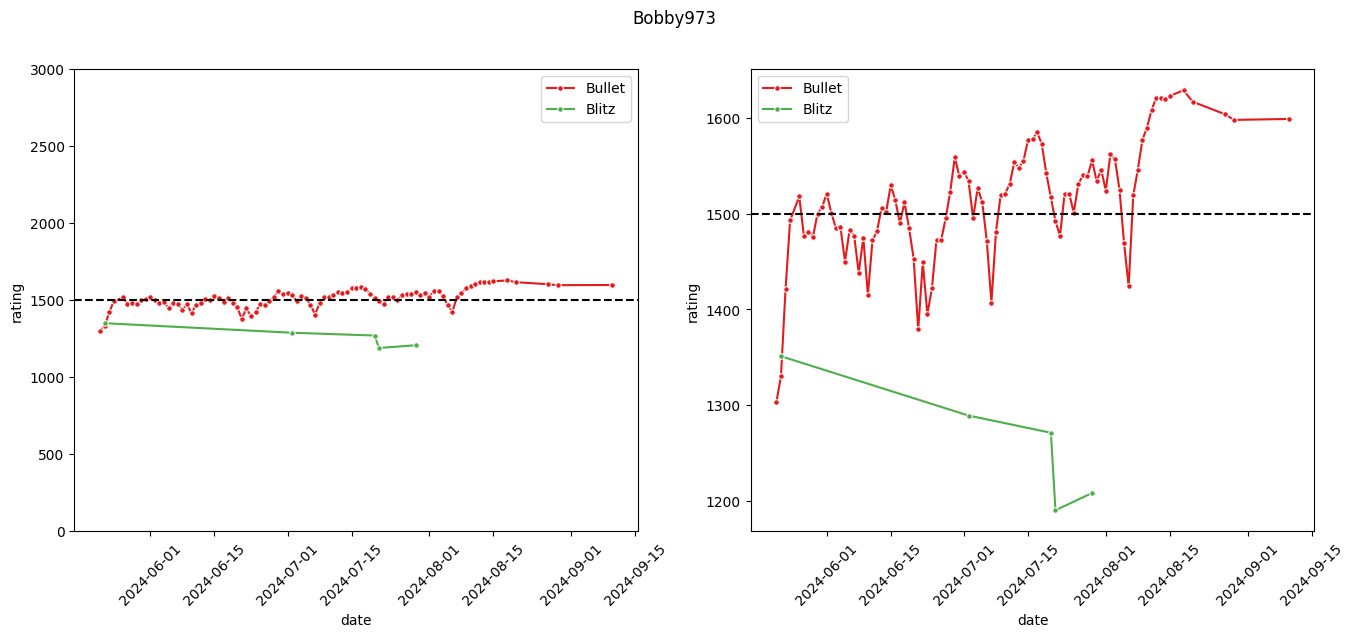

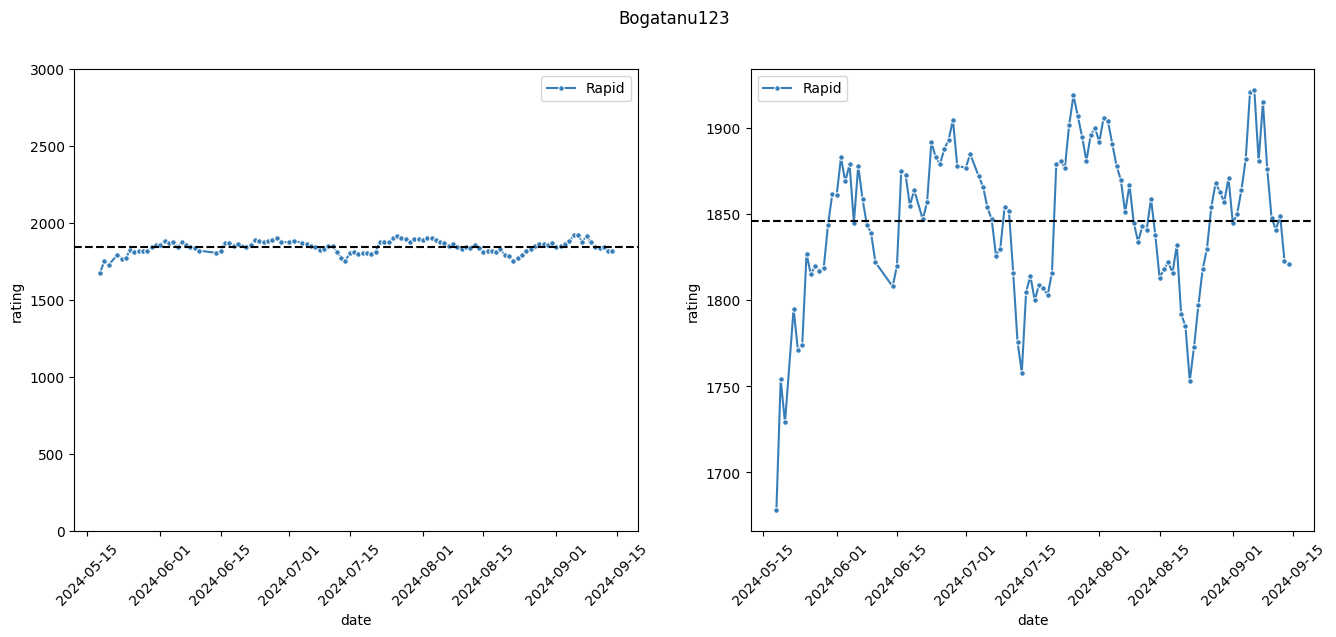

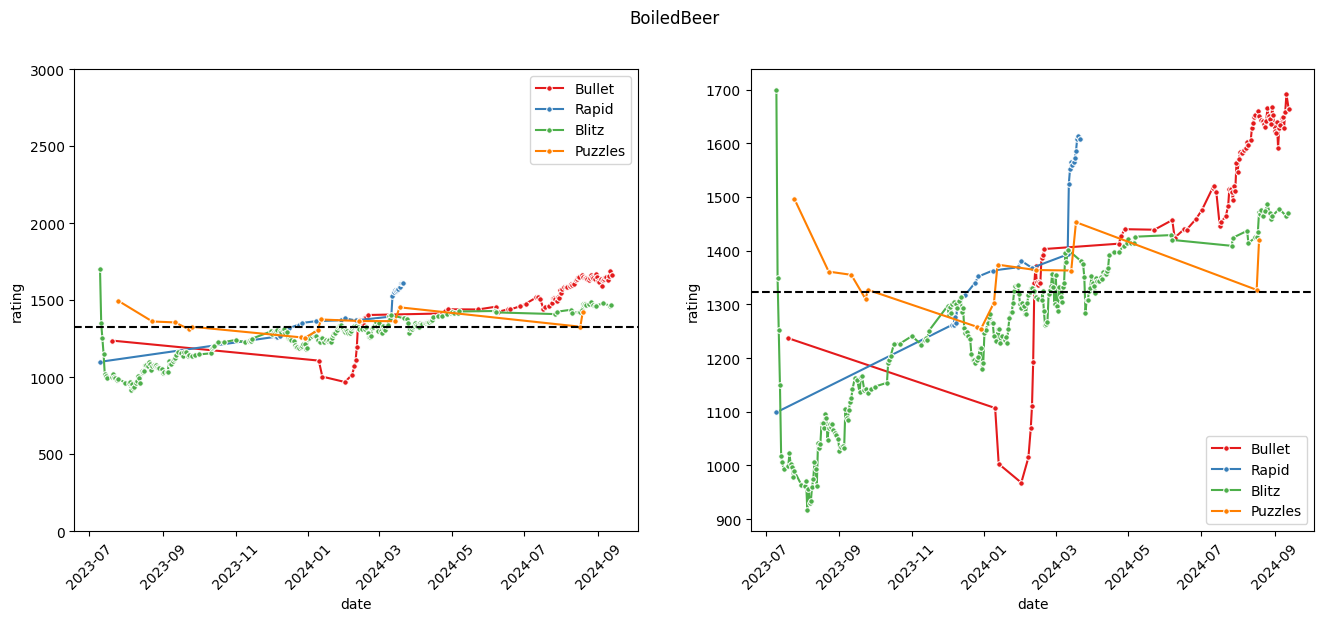

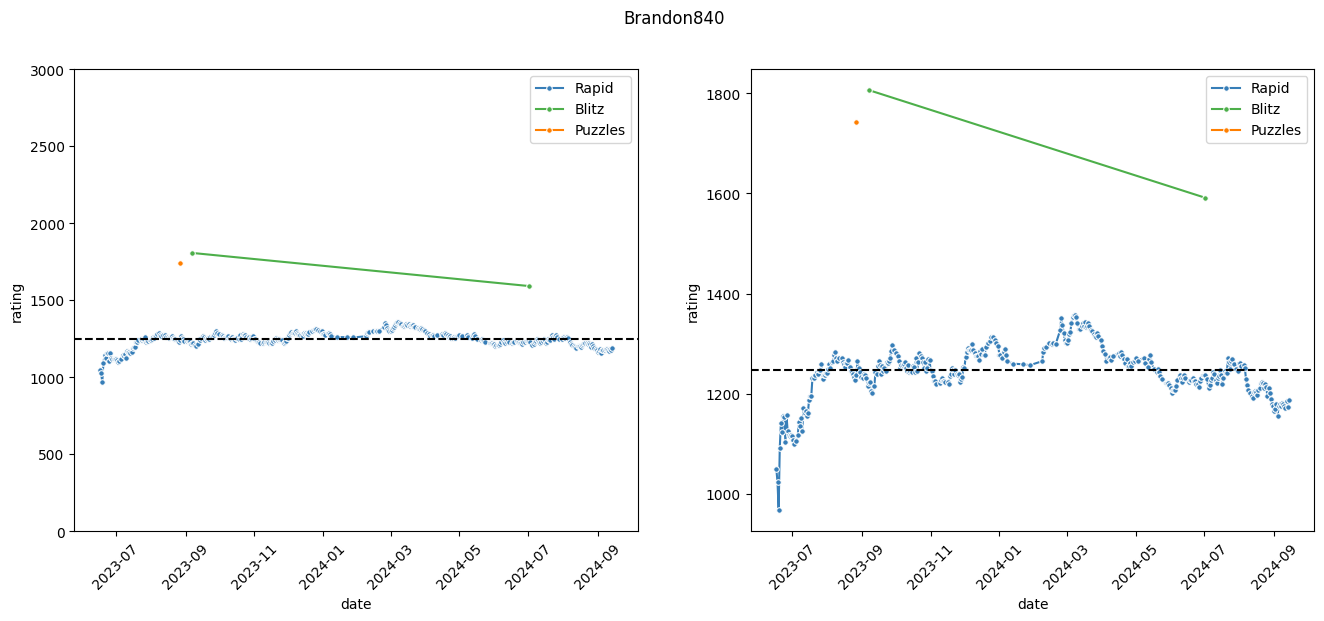

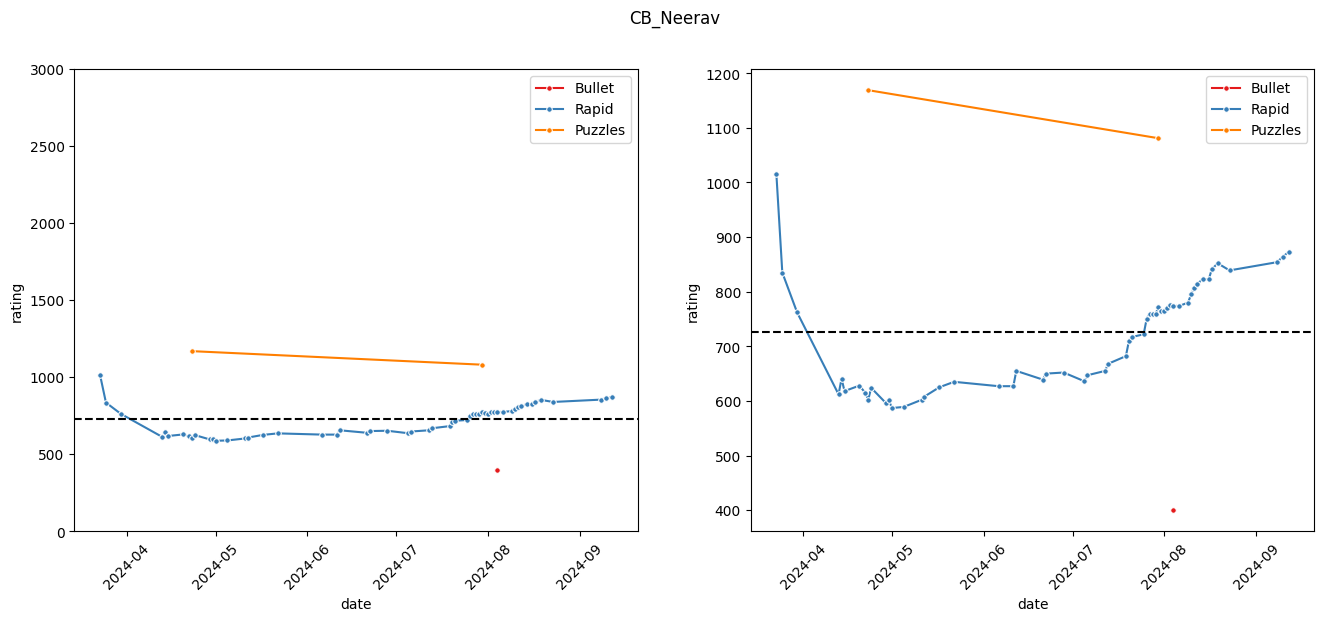

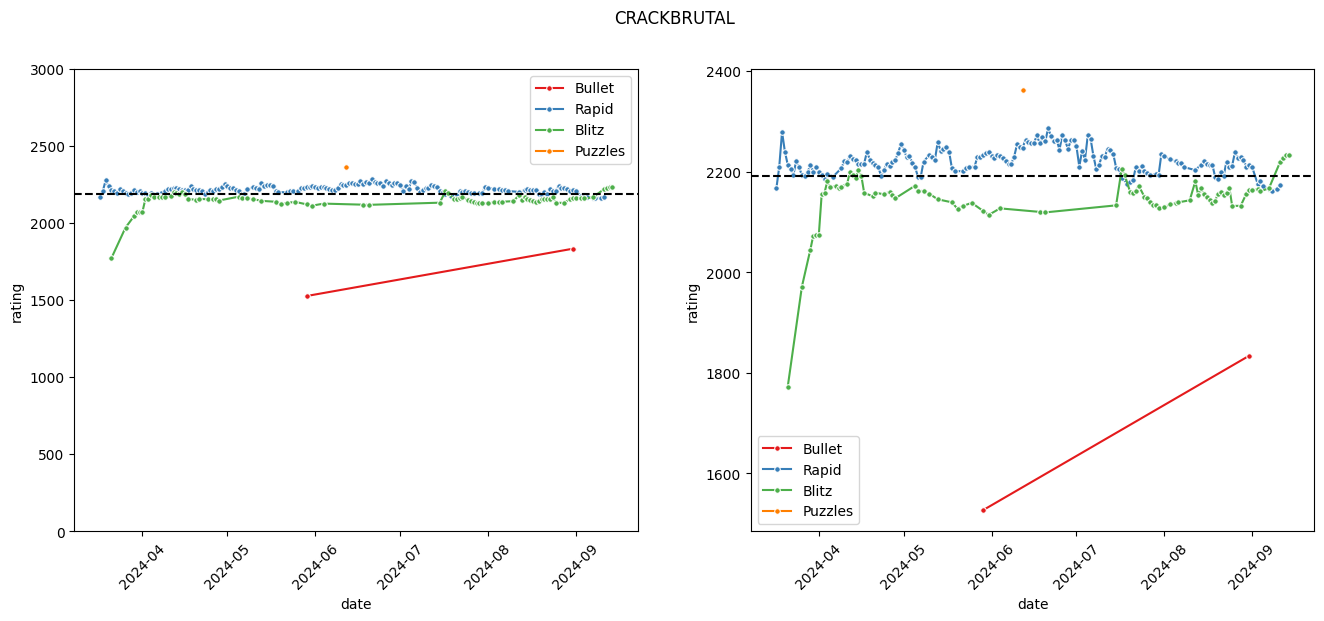

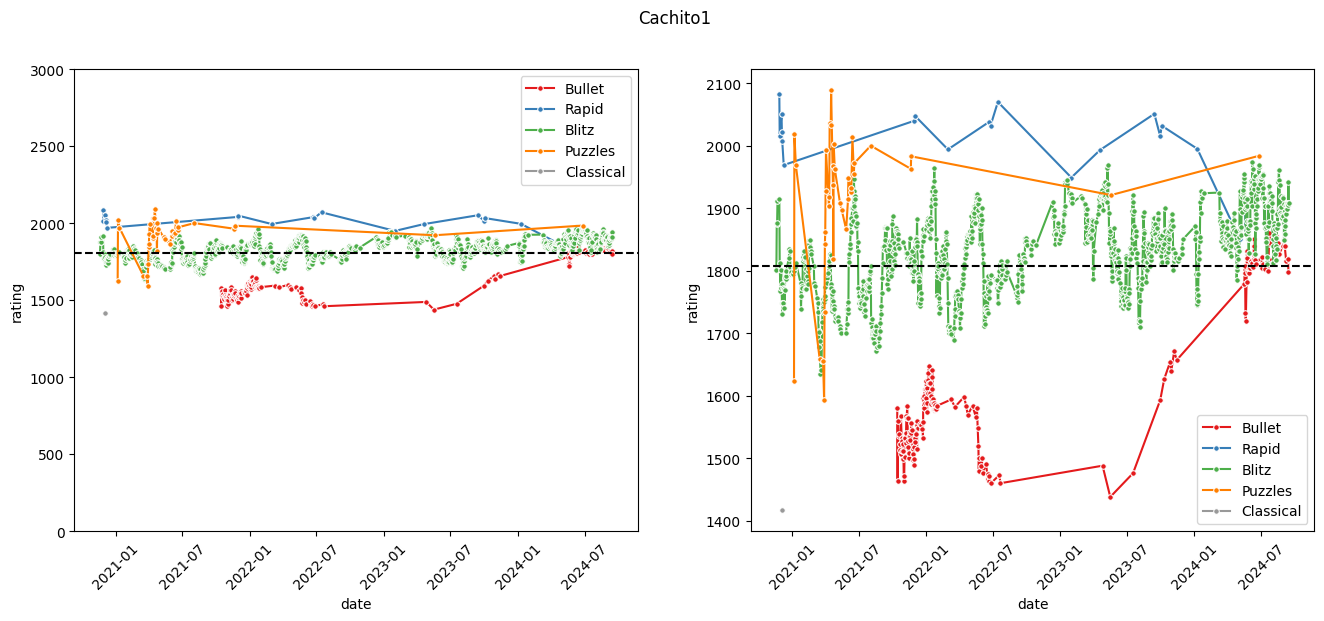

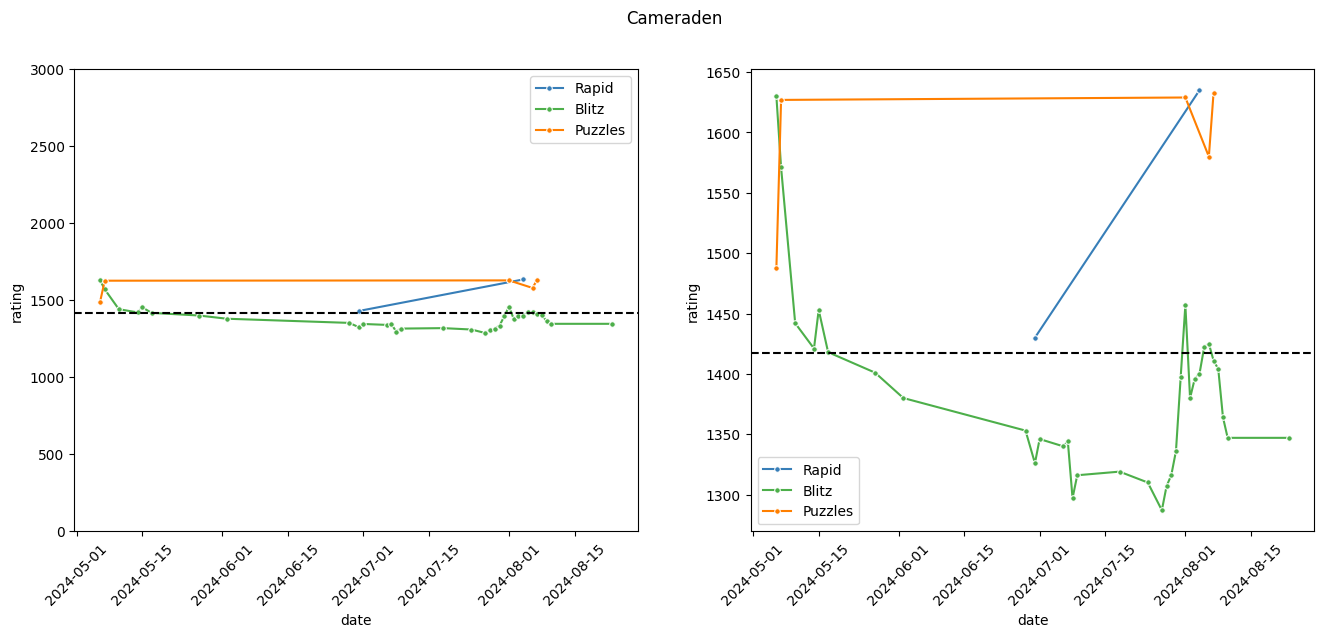

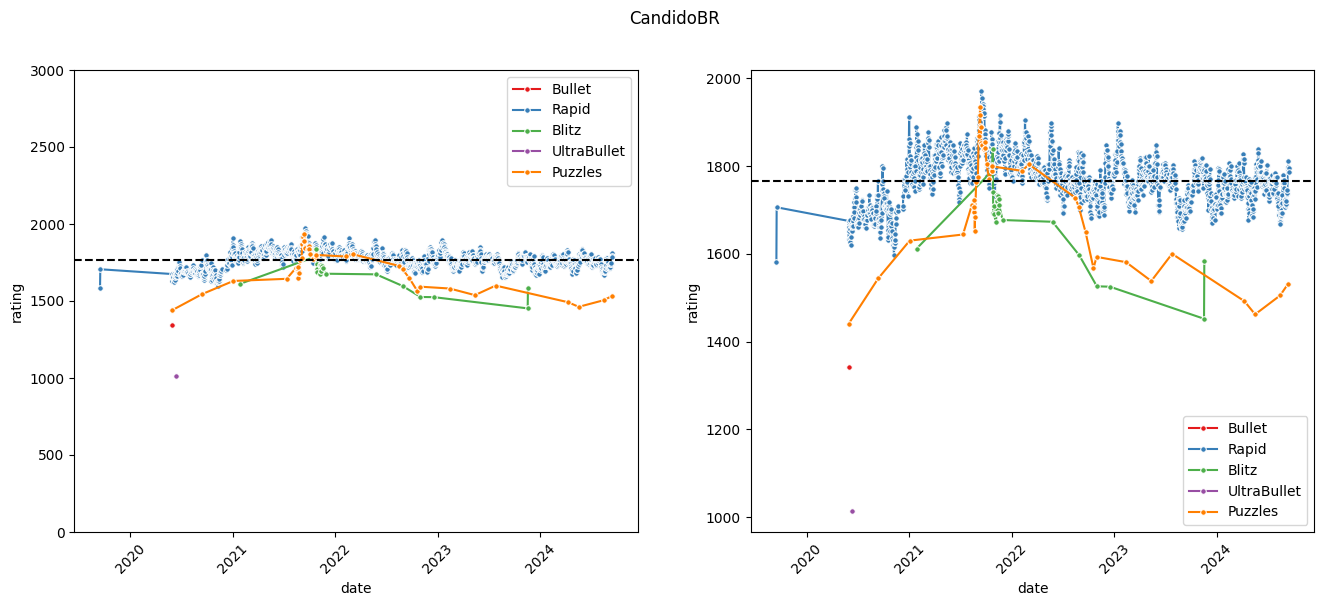

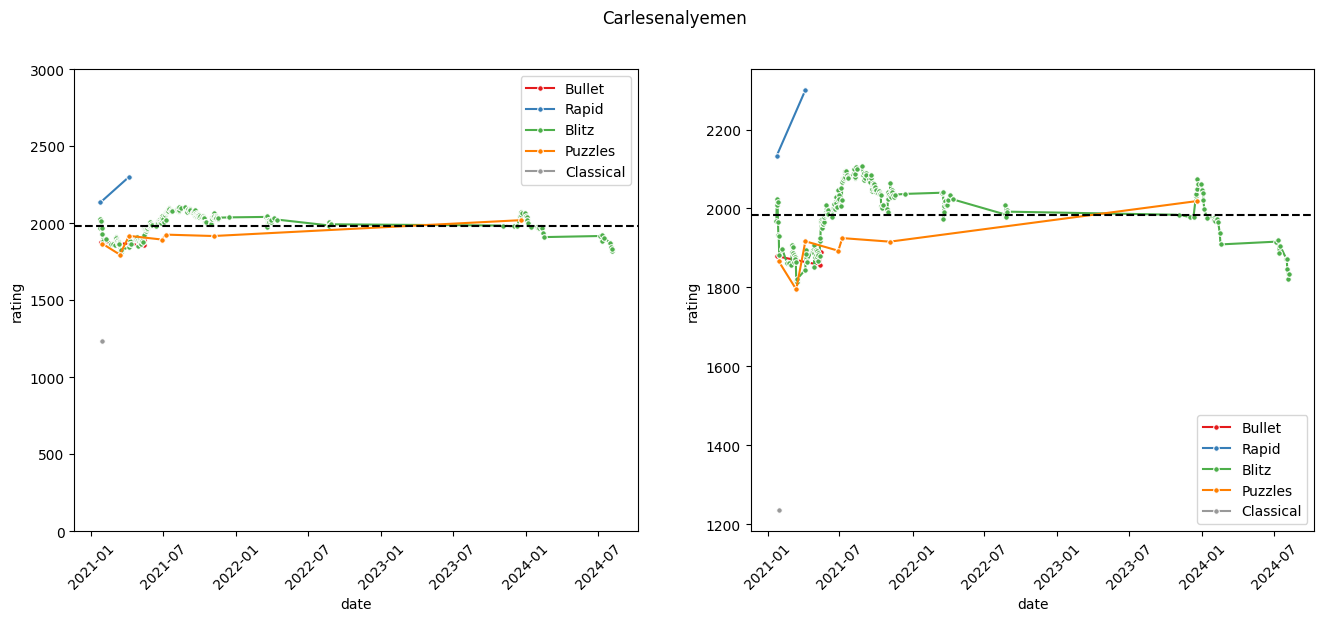

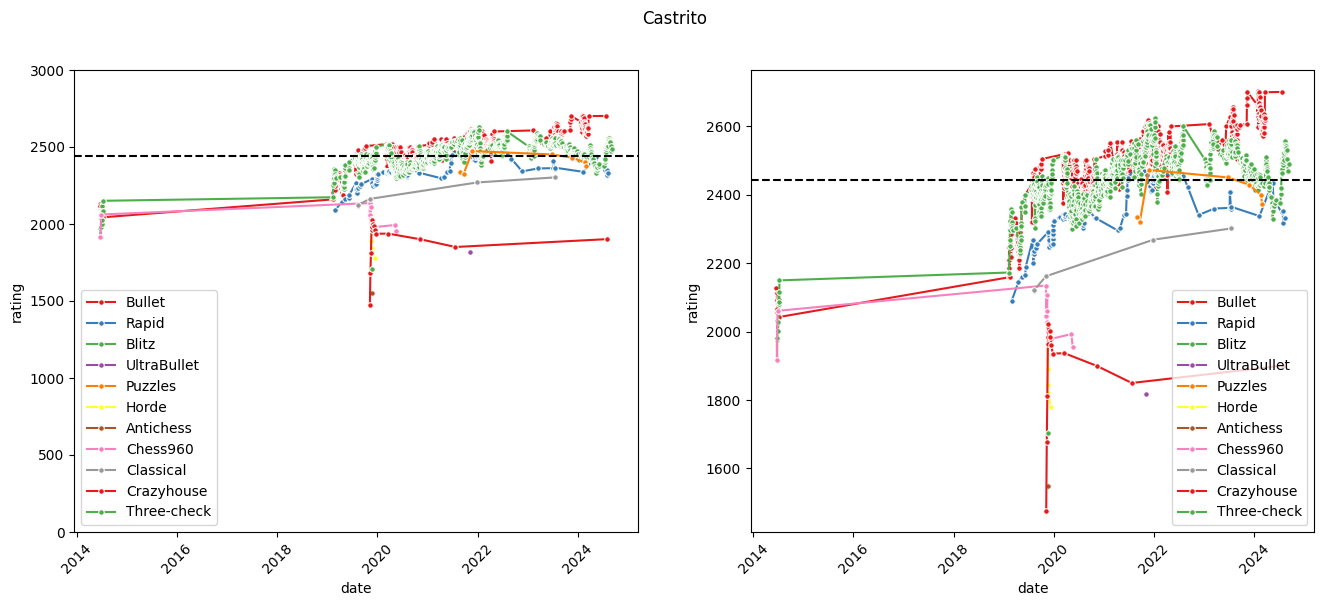

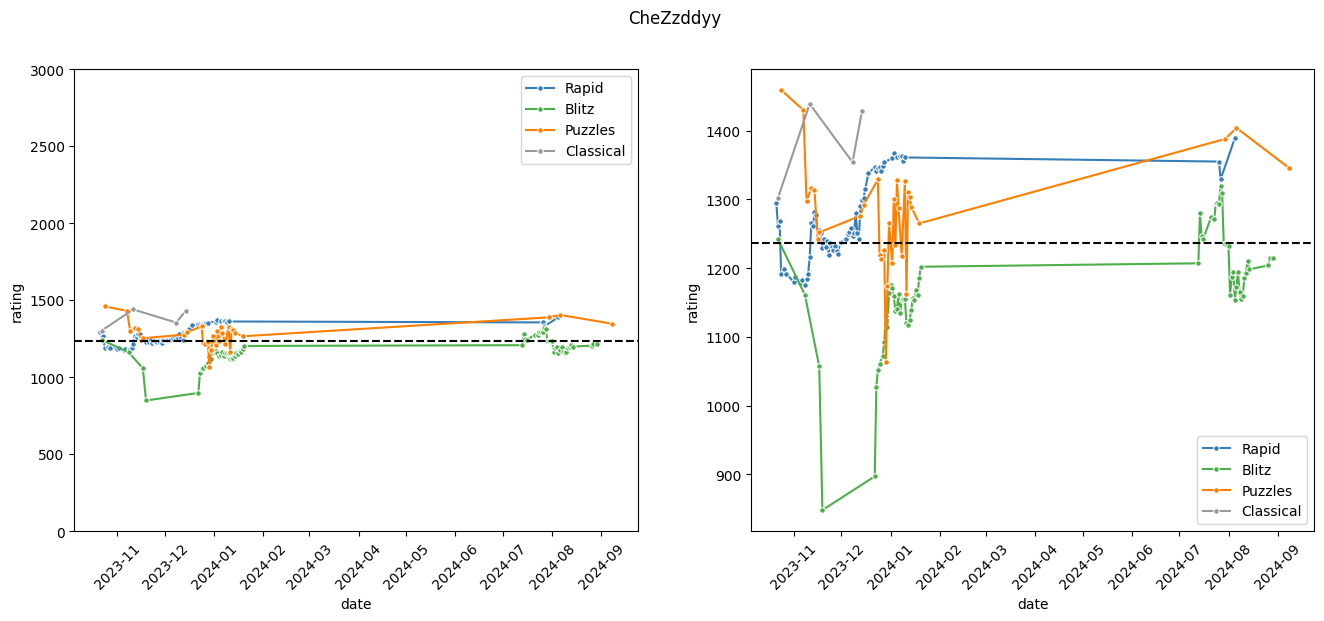

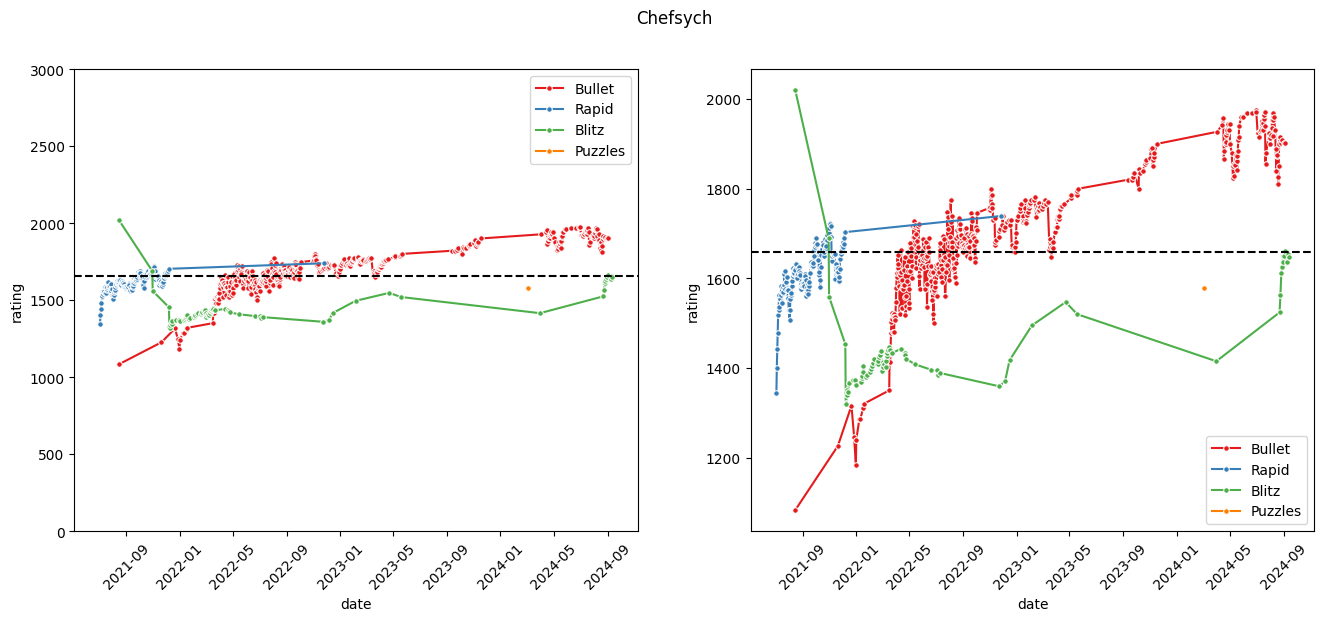

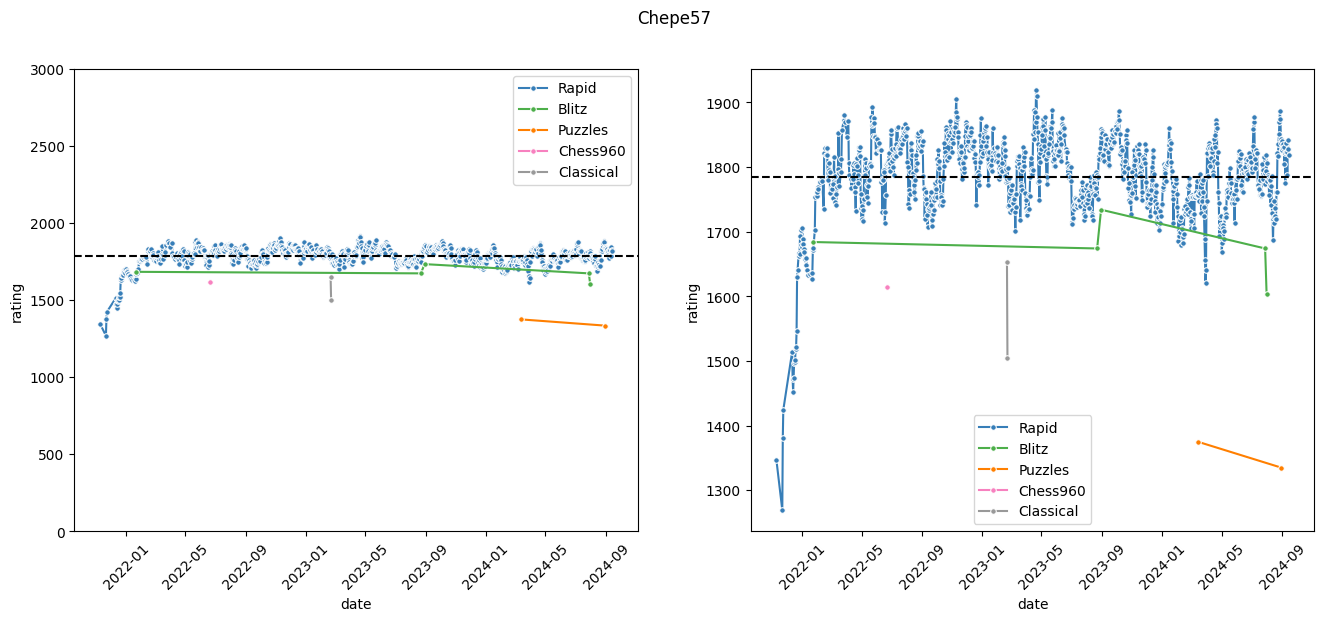

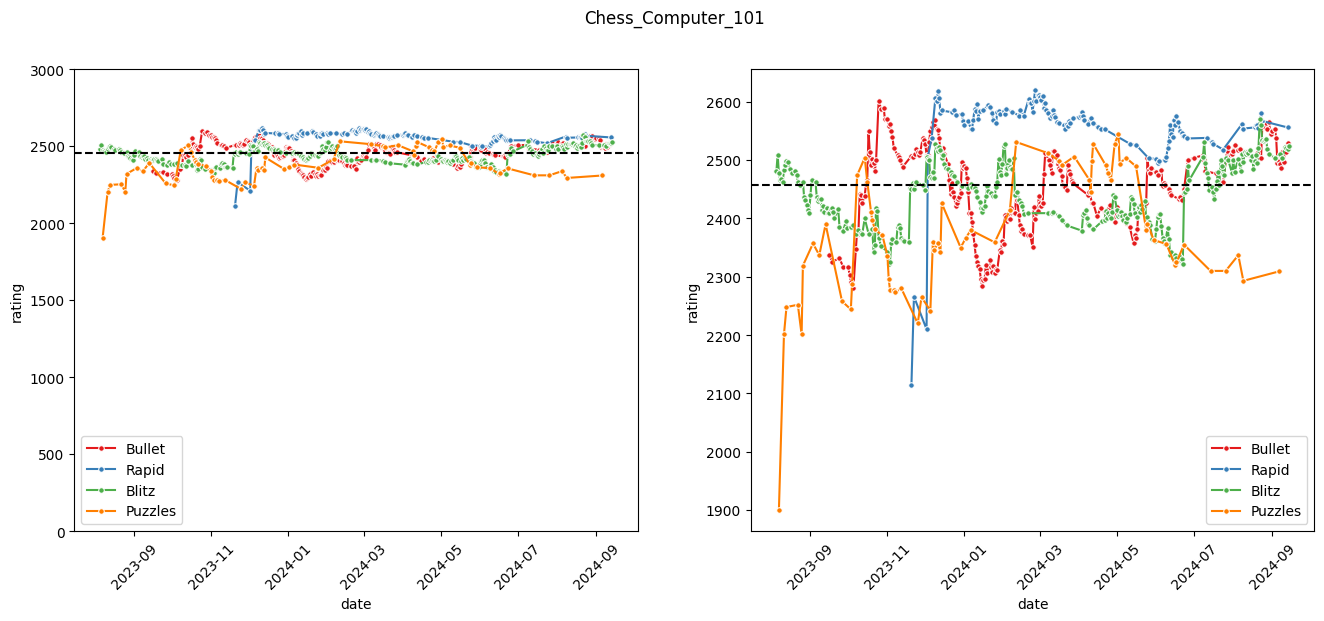

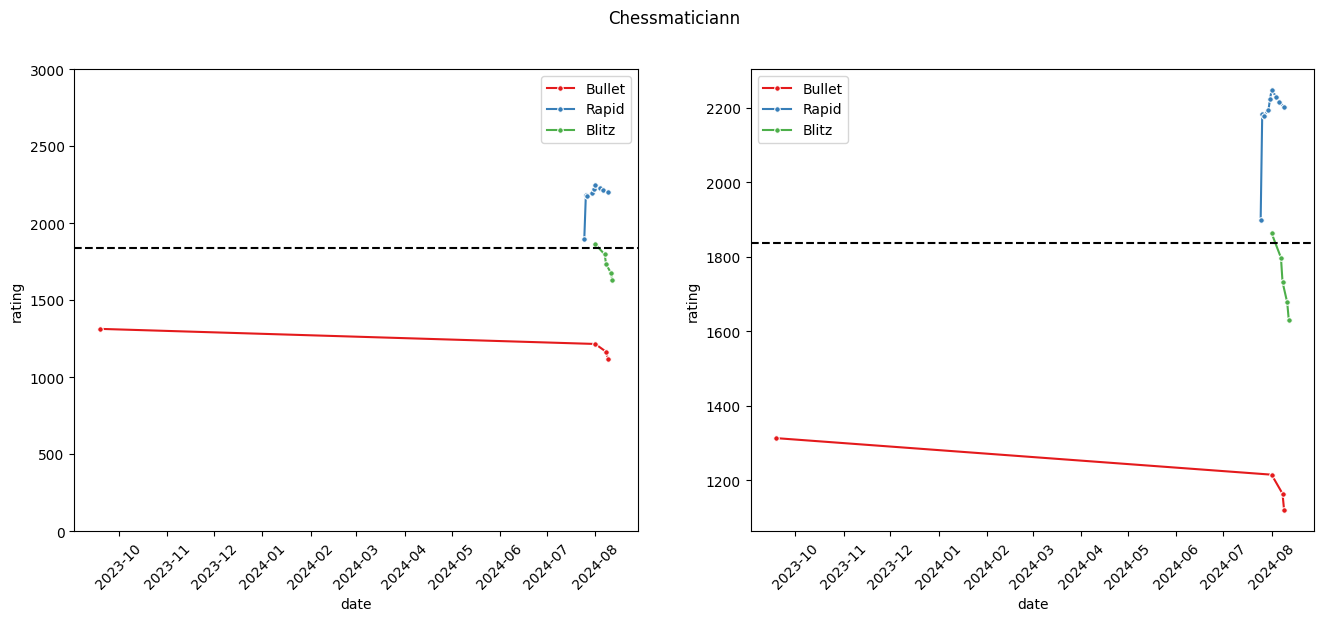

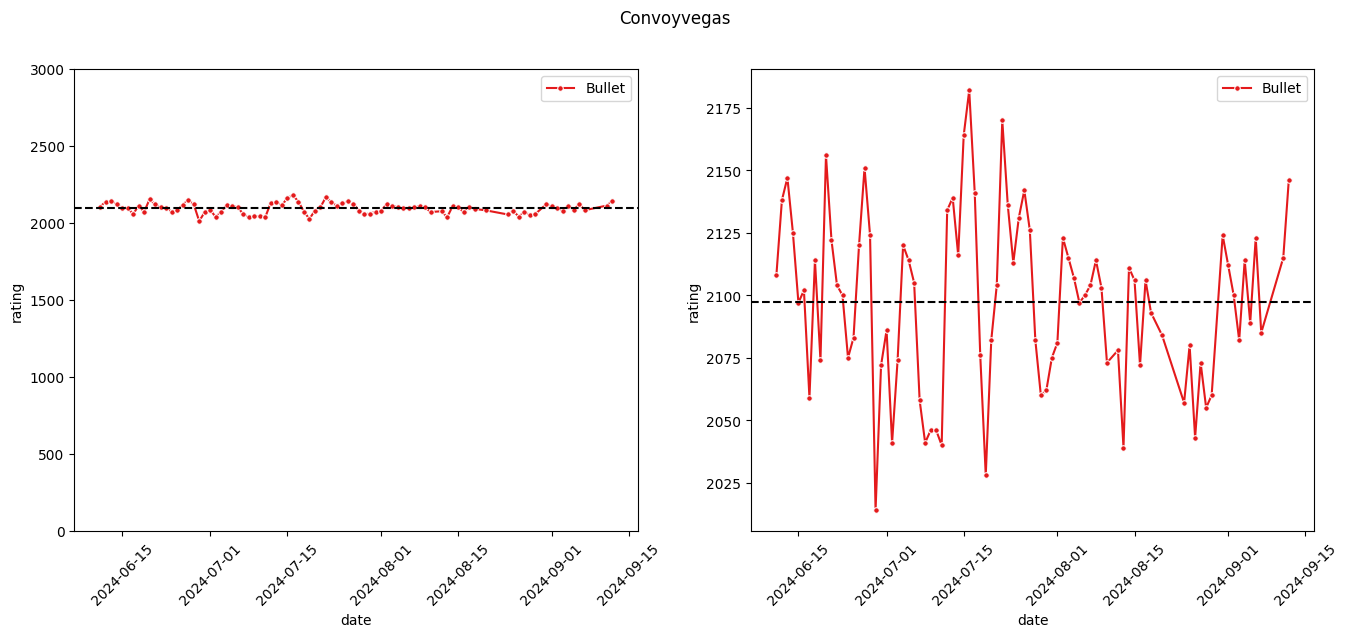

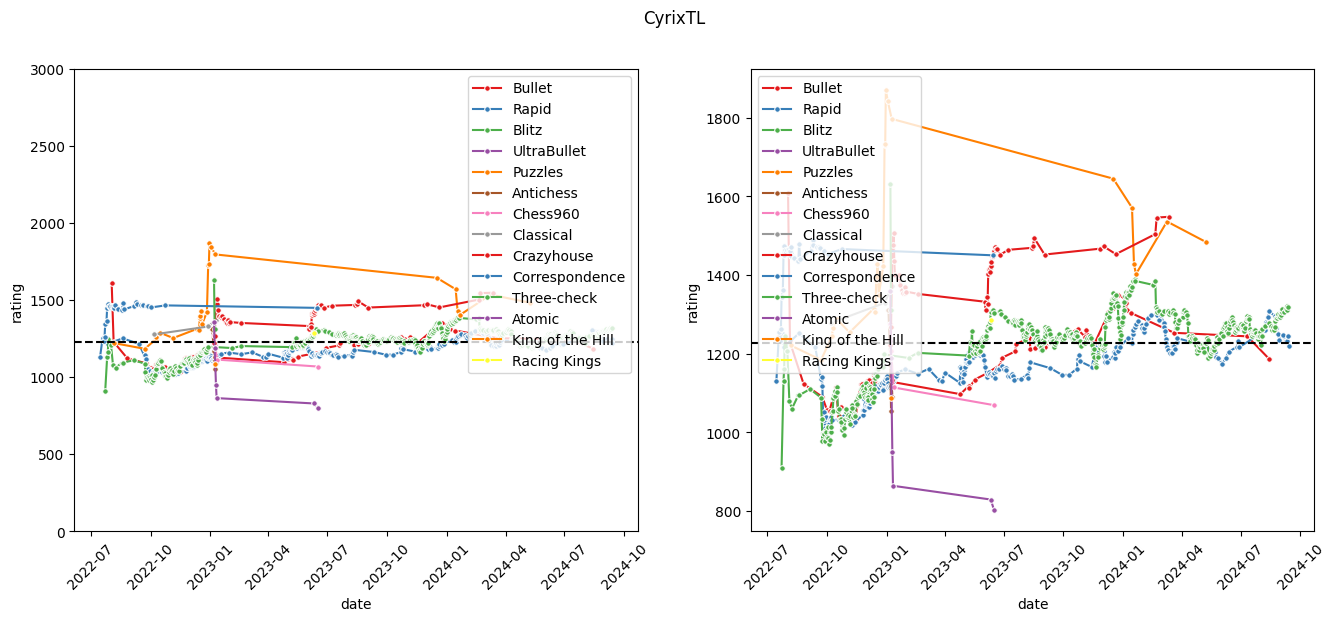

In [165]:
num_cols = 2
num_rows = 25
usernames = all_ratings["username"].unique()
sns.set_palette("Set1")
for user in usernames[:50]:
    fig, ax = plt.subplots(1, 2, figsize=(16,6))
    for i in range(2):
        subset = all_ratings[all_ratings['username'] == user]
        # sort ratings by date:
        subset = subset.sort_values(by='date')
        sns.lineplot(
            subset, 
            x="date", 
            y="rating", 
            hue="mode", 
            hue_order=all_ratings["mode"].unique(), 
            palette="Set1",
            marker=".", 
            markersize= 8, 
            ax=ax[i])
        plt.suptitle(user)
        if i ==0:
            ax[i].set_ylim((0,3000))
        ax[i].axhline(subset["rating"].mean(), 0, 1, color="black", linestyle="--")
        occurring_modes = subset["mode"].unique()
        handles, labels = ax[i].get_legend_handles_labels()
        indices = [i for i, label in enumerate(labels) if label in occurring_modes]
        ax[i].legend(handles=[handles[i] for i in indices], labels=[labels[i] for i in indices])
        ax[i].tick_params(axis='x', rotation=45)
    plt.show()

In [168]:
all_ratings.to_csv("../data/all_ratings_users_active_in_Aug24.csv", index=False)